# **Machine Learning Model for Predicting Used Car Price in UK**

Data Rangers Team :

1. Isharridho Pratama

2. Christianto Octiandi

3. Risnanda Satriatama


# Business Understanding

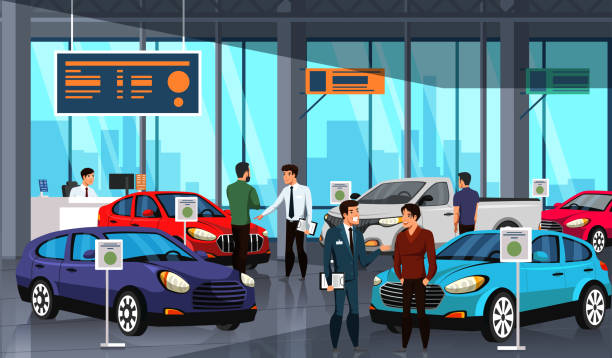

In [ ]:
path = "/Users/BRI9999ADM/Desktop/"
Image(filename = path + "ilustrations.jpg", width=1000, height=1000)

***CONTEXT***

Di tengah menurunnya pasokan mobil baru di Inggris Raya dikarenakan minimnya pasokan semikonduktor, banyak pelanggan mobil yang mulai beralih ke mobil bekas. Hal ini ditunjukkan dari data Society of Motor Manufacturers and Traders (SMMT) pertumbuhan penjualan mobil baru yang hanya 1% pada tahun 2021 dibandingkan dengan mobil bekas yang sebesar 11.5% (SMMT. https://www.smmt.co.uk/category/vehicle-data/used-car-sales-data/).  
PT ABC adalah salah satu lembaga showroom mobil bekas yang berperan sebagai pihak yang membeli mobil bekas dari penjual mobil bekas, baik itu perorangan maupun lembaga dan menjual mobil bekas tersebut kepada calon pembeli. PT ABC akan melakukan penilaian harga mobil bekas yang akan dijual dan juga melakukan  inspeksi dan kurasi untuk memeriksa keadaan mobil. PT ABC mengambil keuntungan 5% dari selisih harga beli dan harga jual mobil bekas.   
Di tengah aktivitas pasar mobil bekas yang terus meningkat, PT ABC ingin dapat mendapat gambaran harga pasar mobil bekas yang akurat. Tim Data Analyst Rangers PT ABC bertugas untuk memprediksi harga mobil bekas sesuai dengan kebutuhan PT ABC.

**PROBLEM STATEMENT**

Di tengah aktivitas pasar mobil bekas yang terus meningkat, kepercayaan  konsumen menjadi sangat penting. Bila harga yang dinilai oleh PT ABC tidak akurat, maka konsumen mobil bekas akan beralih ke pesaing lainnya, sehingga PT ABC akan menderita kerugian.

**GOALS**

Berdasarkan permasalahan tersebut, perusahaan ingin menilai harga mobil bekas dengan sebaik mungkin agar kepercayaan konsumen meningkat dan akhirnya PT ABC menjadi top of mind tempat jual beli mobil bekas.

**METRIC EVALUATION**

Evaluasi metrik yang akan digunakan adalah MAPE, dimana MAPE adalah rataan persentase error yang dihasilkan oleh model regresi. Semakin kecil nilai MAPE yang dihasilkan, berarti model semakin akurat dalam memprediksi harga mobil bekas.

Selain itu, kita juga bisa menggunakan nilai R-squared (R2). Nilai R-squared digunakan untuk mengetahui seberapa baik model dapat merepresentasikan varians keseluruhan data. Semakin mendekati 1, maka semakin fit pula modelnya terhadap data observasi.

# Data Understanding

- Dataset dapat diambil pada link: https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes?datasetId=750216&sortBy=voteCount

**Data Information**

| **Column** | **Data Type** | **Description** |
| --- | --- | --- |
| model | Object | Tipe Model Kendaraan |
| year | Integer | Tahun Pabrikan Kendaraan |
| price | Integer | Harga Kendaraan di Pasar (Poundsterling) |
| transmission | Object | Jenis transmisi kendaraan |
| mileage | Integer | Jarak Tempuh Kendaraan (Mil) |
| fuelType | Object | Jenis Bahan Bakar Kendaraan |
| tax | Integer | Pajak yang Dikenakan pada Kendaraan (Poundsterling) |
| mpg | Float | Ukuran Efisiensi Kendaraan (Mile per Gallon) |
| engineSize | Float | Kapasitas Mesin Kendaraan (Liter) |
| Merk | Object | Merk Kendaraan |

In [ ]:
# # # Just for colab
# !pip install category-encoders

In [ ]:
# !pip install -U xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from IPython.display import Image

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from category_encoders import BinaryEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.compose import TransformedTargetRegressor

# Evaluation
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Read dataframe
merk = ['audi', 'bmw', 'ford', 'hyundi', 'merc', 'skoda', 'toyota', 'vauxhall', 'vw']
merk_put_in = ['Audi', 'BMW', 'Ford', 'Hyundai', 'Mercy', 'Skoda', 'Toyota', 'Vauxhall', 'VW']
complete_merk = ['audi', 'bmw', 'cclass', 'focus', 'ford', 'hyundi', 'merc', 'skoda', 'toyota', 'vauxhall', 'vw']
df_mix = []

for num, kind in enumerate(merk):
    df_mix.append(pd.read_csv(f'{kind}.csv'))

Dataset awal terdiri dari beberapa merk mobil bekas yang terpisah. Oleh karena itu, dilakukan penggabungan data dari semua merk mobil yang tersedia menjadi satu dataset.  
Pada dataset ini, kami tidak menggunakan dataset unclean, focus, dan cclass. Alasan tidak menggunakan dataset unclean dikarenakan banyaknya missing value. Sedangkan pada cclass dan focus, sebagian besar data mobil pada dataset tersebut sudah termasuk pada dataset ford dan juga merc, sehingga menyebabkan banyaknya data duplikat. Selain itu, data cclass dan focus memiliki fitur yang lebih sedikit (hanya 7 fitur) dibandingkan dengan dataset lainnya (9 fitur).

***Put merk in dataframe***

In [ ]:
for num, kind in enumerate(merk):
    df_mix[num]['merk'] = merk_put_in[num]
    
df_mix[3].rename(columns={'tax(£)': 'tax'}, inplace=True)
df = pd.concat(df_mix, axis=0)
df

# df.to_csv('data.csv', index=False)
df.reset_index(drop=True, inplace=True)
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,Audi
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0,Audi
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4,Audi
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0,Audi
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0,Audi
...,...,...,...,...,...,...,...,...,...,...
99182,Eos,2012,5990,Manual,74000,Diesel,125,58.9,2.0,VW
99183,Fox,2008,1799,Manual,88102,Petrol,145,46.3,1.2,VW
99184,Fox,2009,1590,Manual,70000,Petrol,200,42.0,1.4,VW
99185,Fox,2006,1250,Manual,82704,Petrol,150,46.3,1.2,VW


In [ ]:
# Numerical Features Distribution 
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,99187.000000,99187.000000,99187.000000,99187.000000,99187.000000,99187.000000
mean,2017.087723,16805.347656,23058.914213,120.299838,55.166825,1.663280
std,2.123934,9866.773417,21148.523721,63.150926,16.138522,0.557646
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,9999.000000,7425.000000,125.000000,47.100000,1.200000
50%,2017.000000,14495.000000,17460.000000,145.000000,54.300000,1.600000
75%,2019.000000,20870.000000,32339.000000,145.000000,62.800000,2.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


Berdasarkan deskripsi data, tidak terdapat nilai minus namun terlihat adanya nilai 0, seperti pada kolom ***tax*** dan juga kolom ***engineSize***.  
***engineSize*** dengan nilai 0 dapat ditemukan pada mobil- mobil kecil (Passmefast. "Car Engine Size: What Do I Need To Know?". https://www.passmefast.co.uk/car-engine-size#:~:text=Engine%20sizes%2C%20however%2C%20are%20measured,you%20have%20at%20your%20disposal.), sehingga nilai 0 pada kolom tersebut merupakan hal yang wajar.  
Selanjutnya adalah nilai 0 pada kolom ***tax***. Berdasarkan peraturan dari Inggris Raya, mobil yang digunakan oleh penyandang disabilitas, mobil- mobil yang dibuat sebelum tahun 1982, dan mobil listrik tidak dikenakan pajak (gov.uk. "Vehicles exempt from vehicle tax". https://www.gov.uk/vehicle-exempt-from-vehicle-tax). Oleh karena itu, nilai 0 pada kolom ***tax*** bukan merupakan sebuah anomali.

In [ ]:
df[df['tax']==0]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
30,A1,2015,9500,Automatic,54754,Diesel,0,76.3,1.6,Audi
50,A4,2016,12750,Manual,52561,Diesel,0,74.3,2.0,Audi
58,A3,2016,10200,Manual,66369,Diesel,0,83.1,1.6,Audi
60,A1,2013,7000,Manual,76269,Diesel,0,74.3,1.6,Audi
69,A1,2016,10800,Manual,18181,Petrol,0,67.3,1.0,Audi
...,...,...,...,...,...,...,...,...,...,...
98724,Golf SV,2016,10550,Manual,16739,Diesel,0,72.4,1.6,VW
98726,Golf SV,2015,8950,Manual,45000,Diesel,0,72.4,1.6,VW
98731,Golf SV,2015,9695,Manual,21151,Diesel,0,72.4,1.6,VW
98751,Golf SV,2014,8650,Manual,32535,Diesel,0,72.4,1.6,VW


In [ ]:
# Count Dataset and Check Column's Datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99187 entries, 0 to 99186
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         99187 non-null  object 
 1   year          99187 non-null  int64  
 2   price         99187 non-null  int64  
 3   transmission  99187 non-null  object 
 4   mileage       99187 non-null  int64  
 5   fuelType      99187 non-null  object 
 6   tax           99187 non-null  int64  
 7   mpg           99187 non-null  float64
 8   engineSize    99187 non-null  float64
 9   merk          99187 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 7.6+ MB


In [ ]:
# Show Unique Values
data_cols=df.select_dtypes(include='object')
for col in data_cols:
    print('''\033[1mValue Counts {}\033[0m'''.format(col))
    print(data_cols[col].value_counts())
    print()

Value Counts model
 Fiesta     6557
 Golf       4863
 Focus      4588
 C Class    3747
 Corsa      3441
            ... 
 Ranger        1
200            1
 A2            1
 RS7           1
 Amica         1
Name: model, Length: 195, dtype: int64

Value Counts transmission
Manual       56445
Semi-Auto    22677
Automatic    20056
Other            9
Name: transmission, dtype: int64

Value Counts fuelType
Petrol      54928
Diesel      40928
Hybrid       3078
Other         247
Electric        6
Name: fuelType, dtype: int64

Value Counts merk
Ford        17965
VW          15157
Vauxhall    13632
Mercy       13119
BMW         10781
Audi        10668
Toyota       6738
Skoda        6267
Hyundai      4860
Name: merk, dtype: int64



In [ ]:
# Unique Value for Year Column
df.year.unique()

array([2017, 2016, 2019, 2015, 2014, 2018, 2013, 2020, 2004, 2009, 2012,
       2010, 2007, 2011, 2008, 2003, 2005, 2002, 2006, 1998, 1997, 2001,
       2000, 1999, 1996, 2060, 1970], dtype=int64)

Pada bagian ini, terlihat adanya nilai yang tidak masuk akal, yaitu tahun ***2060*** dan ***1970***. Kami akan melakukan preprocessing data pada bagian data preprocessing.

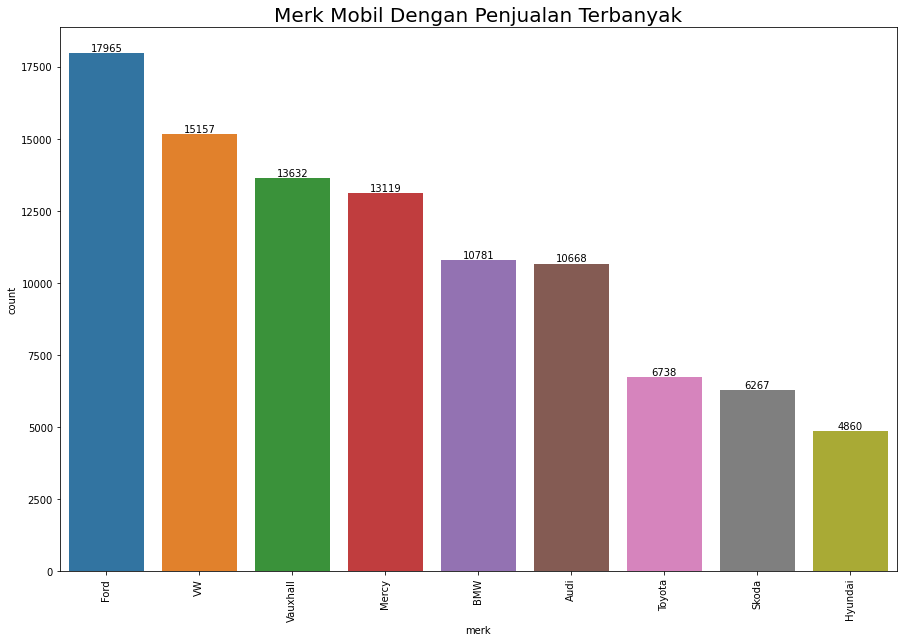

In [ ]:
plt.figure(figsize=(15,10))
df_merk=sns.countplot(df['merk'],order = df['merk'].value_counts().index)
df_merk.bar_label(df_merk.containers[0])
plt.xticks(rotation=90)
plt.title ('Merk Mobil Dengan Penjualan Terbanyak', size = 20)
plt.show()

Terlihat dari grafik di atas, mobil bekas yang paling banyak terjual di Inggris adalah merk **Ford** diikuti oleh merk **VW**.

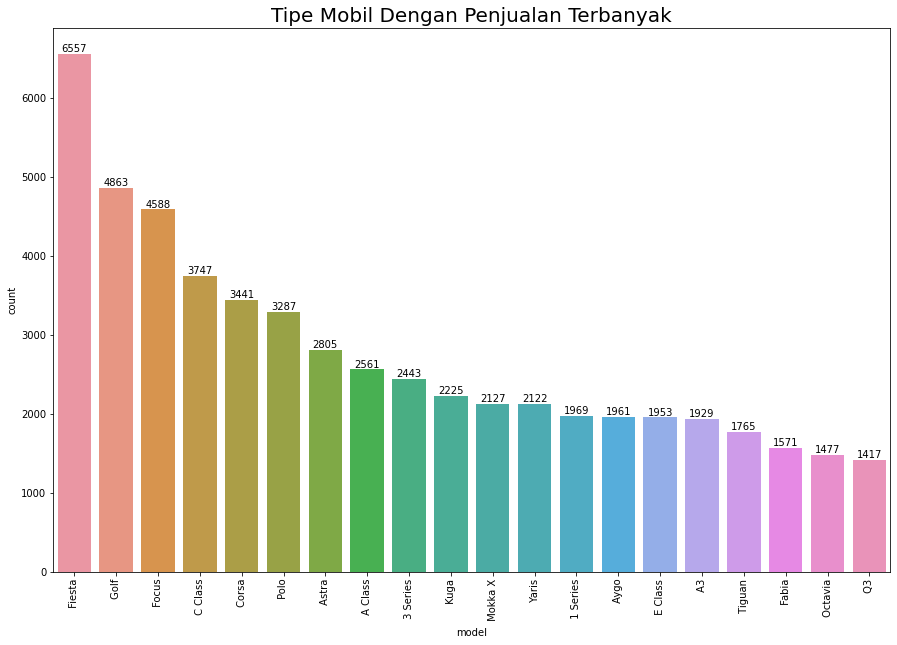

In [ ]:
plt.figure(figsize=(15,10))
df_model=sns.countplot(df['model'],order = df['model'].value_counts().iloc[:20].index)
df_model.bar_label(df_model.containers[0])
plt.xticks(rotation=90)
plt.title ('Tipe Mobil Dengan Penjualan Terbanyak', size = 20)
plt.show()

Berdasarkan grafik diatas, terlihat model **Ford Fiesta** menjadi model yang paling banyak terjual. Selain itu, hampir semua model yang paling banyak terjual masuk ke kategori mobil kecil dan juga city car, kecuali **Mercedes C-Class** yang termasuk ke dalam kategori mobil mewah.

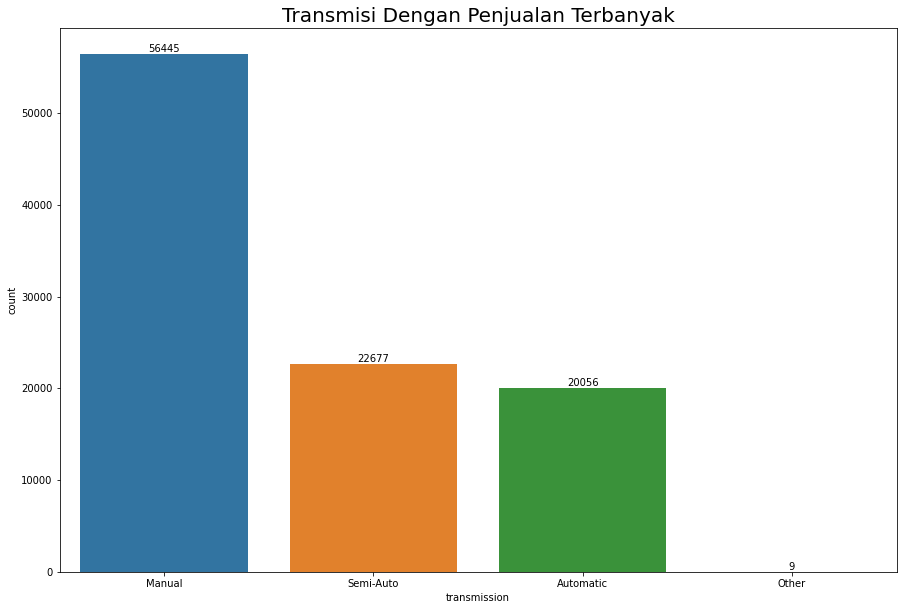

In [ ]:
plt.figure(figsize=(15,10))
df_trans=sns.countplot(df['transmission'],order = df['transmission'].value_counts().index)
df_trans.bar_label(df_trans.containers[0])
plt.title ('Transmisi Dengan Penjualan Terbanyak', size = 20)
plt.show()

Berdasarkan grafik diatas, terlihat transmisi ***Manual*** merupakan jenis transmisi yang paling banyak terjual.

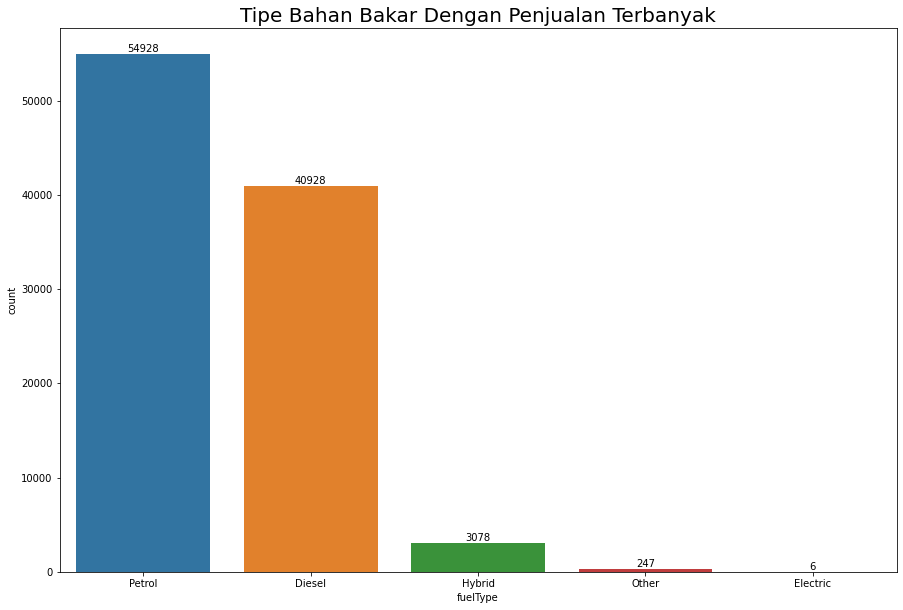

In [ ]:
plt.figure(figsize=(15,10))
df_fuelType=sns.countplot(df['fuelType'],order = df['fuelType'].value_counts().index)
df_fuelType.bar_label(df_fuelType.containers[0])
plt.title ('Tipe Bahan Bakar Dengan Penjualan Terbanyak', size = 20)
plt.show()

Berdasarkan grafik diatas, terlihat mobil dengan bahan bakar ***Petrol*** dan ***Diesel*** merupakan jenis mobil yang paling banyak terjual.

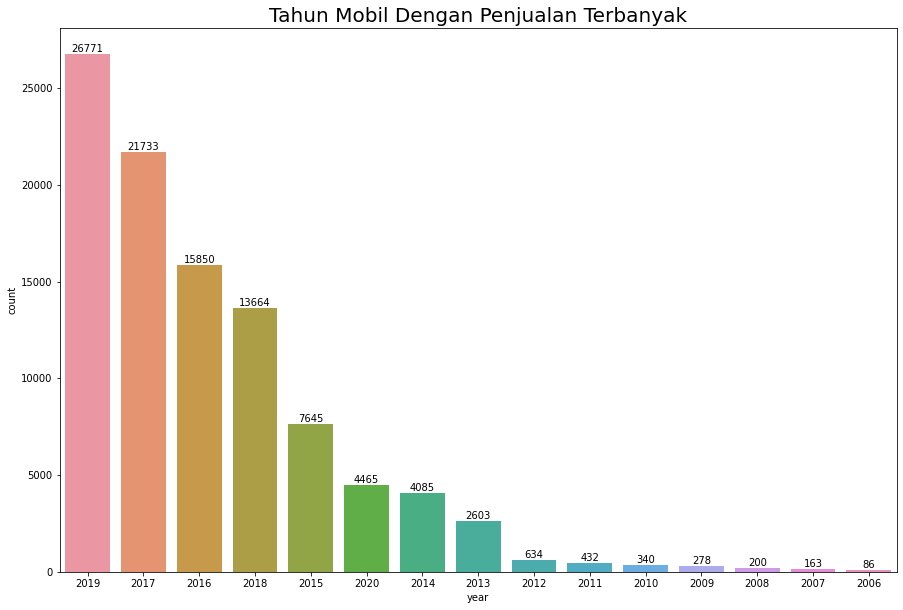

In [ ]:
plt.figure(figsize=(15,10))
df_year=sns.countplot(df['year'],order = df['year'].value_counts().iloc[:15].index)
df_year.bar_label(df_year.containers[0])
plt.title ('Tahun Mobil Dengan Penjualan Terbanyak', size = 20)
plt.show()

Berdasarkan grafik diatas, terlihat mobil pabrikan enam tahun terakhir merupakan mobil yang paling banyak terjual, terutama pada tahun ***2019***. Pengecualian terjadi pada tahun ***2020*** yang penjualannya terlihat tidak sebanyak tahun- tahun lainnya di rentang enam tahun terakhir.

In [ ]:
df_by1=df[['model','price']].groupby(df['year']).mean().sort_values(by='price',ascending=False).head(20)
df_by2=df[['model','price']].groupby(df['model']).mean().sort_values('price',ascending=False).head(20)
df_by3=df[['transmission','price']].groupby(df['transmission']).mean().sort_values('price',ascending=False)
df_by4=df[['fuelType','price']].groupby(df['fuelType']).mean().sort_values('price',ascending=False)

from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))
    
display_side_by_side([df_by1, df_by2, df_by3, df_by4], ['Average Price by Year', 'Average Price by Model', 'Average Price by Transmission','Average Price by Fuel Type'])

,price
year,
2020,28392.529451
2019,23525.855553
1970,17747.000000
2018,16241.165471
2017,14365.755165
2016,13286.618107
2015,11653.298365
2014,9953.922154
2013,8596.344602


Beberapa dataframe di atas menunjukkan relasi beberapa fitur seperti ***year***, ***model***, ***transmission***, dan ***fuelType*** dengan ***price***.  

Pada dataframe pertama, terlihat mobil yang memiliki rata-rata nilai ***price*** tertinggi adalah mobil pabrikan terbaru (5 tahun terakhir). Pengecualian terlihat pada tahun 1970, yang berada pada urutan ketiga. 

Pada dataframe kedua, terlihat mobil- mobil mewah dari merk **Mercedes G Class**, **Audi R8**, **BMW X7**, dan **BMW 8 Series** merupakan mobil- mobil dengan rata- rata nilai ***price*** tertinggi.  

Pada dataframe ketiga, terlihat mobil- mobil dengan transmisi **Semi-auto** dan **Automatic** merupakan mobil yang memiliki nilai rata- rata ***price*** paling mahal.  

Pada dataframe keempat, terlihat bahwa mobil berbahan bakar **Diesel** dan **Hybrid** merupakan tipe mobil yang memiliki nilai rata- rata ***price*** paling mahal.  

Text(0.5, 1.0, 'Engine Size vs Price Scatterplot')

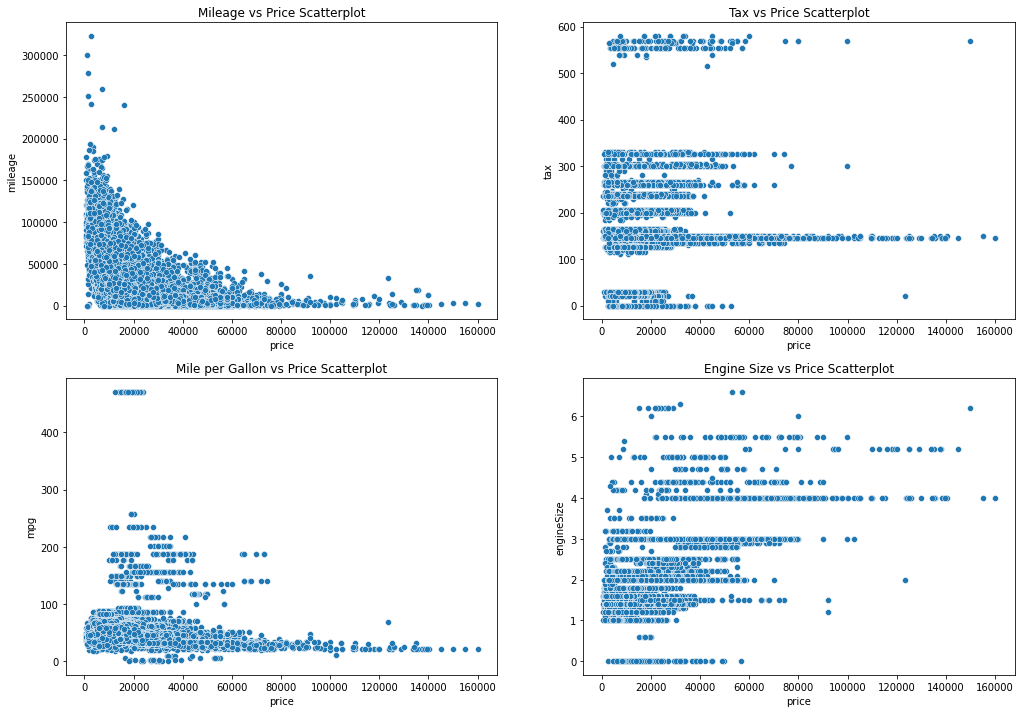

In [ ]:
plt.figure(figsize=(17,12))

plt.subplot(221)
sns.scatterplot(x='price',y='mileage',data=df)
plt.title('Mileage vs Price Scatterplot')

plt.subplot(222)
sns.scatterplot(x='price',y='tax',data=df)
plt.title('Tax vs Price Scatterplot')

plt.subplot(223)
sns.scatterplot(x='price',y='mpg',data=df)
plt.title('Mile per Gallon vs Price Scatterplot')

plt.subplot(224)
sns.scatterplot(x='price',y='engineSize',data=df)
plt.title('Engine Size vs Price Scatterplot')

Beberapa grafik scatterplot di atas menjelaskan tentang hubungan variabel- variabel numerik pada dataset dengan fitur ***price***.  

Berdasarkan grafik- grafik di atas, terlihat hubungan antar fitur- fitur numerik dengan ***price*** cenderung acak. Namun, ada sedikit korelasi negatif yang tergambar pada scatterplot fitur ***mileage*** dan ***price***. Pada grafik tersebut, terlihat bahwa semakin tinggi ***mileage***, maka nilai ***price*** akan semakin rendah. Hal tersebut mengindikasikan semakin baru kondisi mobil, semakin tinggi harga jualnya.

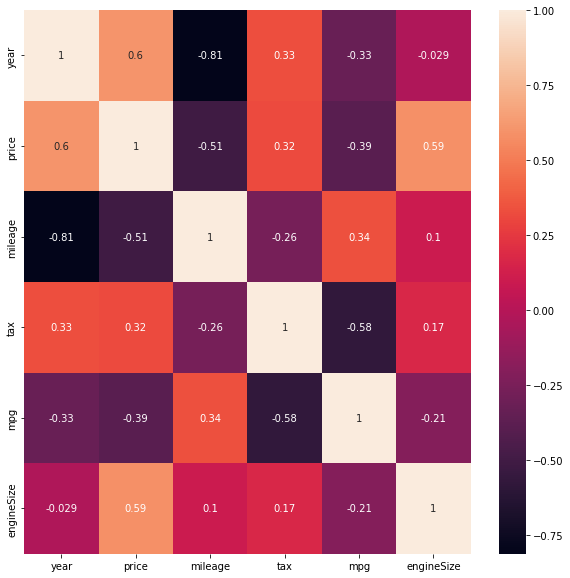

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr('spearman'),annot=True)
plt.show()

Pada grafik korelasi di atas terlihat beberapa fitur memiliki korelasi yang cukup kuat dengan ***price***.  

Fitur ***year*** memiliki korelasi positif dengan ***price*** menandakan semakin tinggi nilai tahun (dalam konteks ini adalah semakin baru), maka harga mobil akan semakin mahal.  

Fitur ***mileage*** memiliki korelasi negatif dengan ***price*** menandakan semakin kecil nilai ***mileage*** maka harga mobil akan semakin mahal.
  
Fitur ***engineSize*** memiliki korelasi positif dengan ***price*** menandakan semakin tinggi kapasitas mesin mobil, maka harga mobil akan semakin mahal.

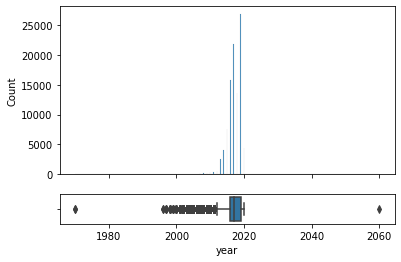

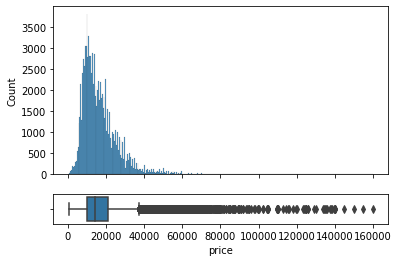

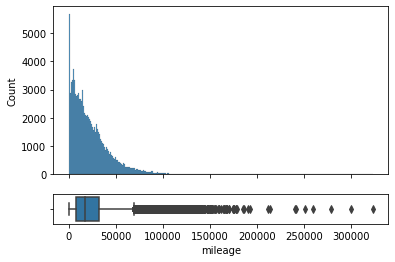

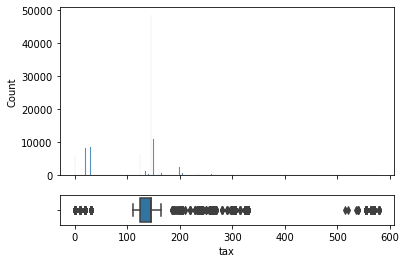

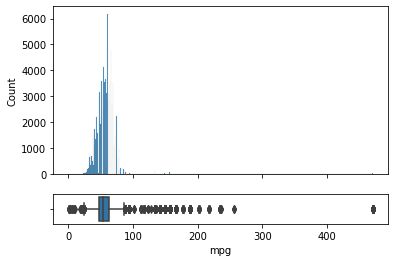

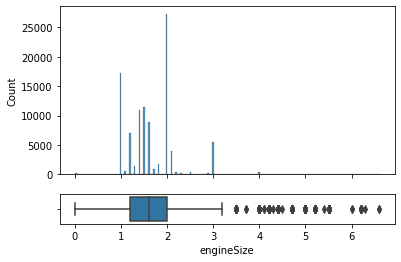

In [ ]:
# sns.set(style="darkgrid")

for col in df.describe().columns:
    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.85, .15)})

    # assigning a graph to each ax
    sns.histplot(data=df, x=col, ax=ax_hist)
    sns.boxplot(df[col], ax=ax_box)
    plt.show()
plt.show()

Grafik- grafik di atas menjelaskan mengenai distribusi data dari fitur- fitur numerik pada dataset.  

Terlihat sebagian besar data memiliki distribusi tidak normal, *right skewed*, dan memiliki outlier.  

Terdapat outlier yang terlihat tidak wajar pada fitur ***year*** dan fitur ***mpg***.  

Fitur ***year*** memiliki nilai outlier ekstrem di bagian kiri dan juga kanan. Hal ini berasal dari nilai tahun ***1970*** dan ***2060*** yang akan diproses pada bagian data preprocessing.  

Fitur ***mpg*** memiliki nilai outlier ekstrem di bagian kanan. Hal ini akan ditelaah lebih lanjut sebelum diputuskan mengenai treatment outlier tersebut.

In [ ]:
# Checking mpg outlier
df_mpg=df.sort_values(by='mpg',ascending=False).head(50)
df_mpg

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
19503,i3,2015,17400,Automatic,29465,Electric,0,470.8,1.0,BMW
11448,i3,2017,21898,Automatic,10839,Hybrid,0,470.8,0.0,BMW
19927,i3,2015,12500,Automatic,79830,Hybrid,0,470.8,0.0,BMW
15534,i3,2014,14495,Automatic,34539,Hybrid,0,470.8,0.0,BMW
16413,i3,2017,19000,Automatic,23983,Hybrid,0,470.8,0.0,BMW
17715,i3,2017,19948,Automatic,20929,Hybrid,135,470.8,0.0,BMW
18856,i3,2015,14940,Automatic,59000,Other,0,470.8,0.6,BMW
17752,i3,2017,22495,Automatic,21025,Hybrid,0,470.8,0.0,BMW
14879,i3,2015,15498,Automatic,33931,Hybrid,0,470.8,0.0,BMW
14581,i3,2017,18500,Automatic,36429,Hybrid,0,470.8,0.0,BMW


Dataframe di atas menunjukkan bahwa nilai outlier ***mpg*** yang tinggi berasal dari satu model mobil, yaitu ***BMW i3***.  

Berdasarkan data tersebut, kami beranggapan bahwa data outlier ini merupakan *natural variance*, sehingga pengolahan outlier tidak dilakukan.

# Data Preparation

### ***Data Cleaning***

***Duplicate Data***

Berdasarkan hasil EDA, terdapat data duplikat yang berjumlah sekitar 1475 data. Data tersebut akan dihapus dan menyisakan data sekitar ***97712*** data

In [ ]:
df_new = df.copy()

df_new.duplicated().sum()

1475

In [ ]:
df.shape

(99187, 10)

In [ ]:
df_new = df_new.drop_duplicates(keep='first').reset_index(drop=True)
df_new.shape

(97712, 10)

***Data Anomaly Handle***

a. Year Anomaly

Berdasarkan hasil EDA, fitur ***year*** memiliki data anomali yaitu tahun ***2060*** dan ***1970*** seperti yang dapat dilihat sebagai berikut.

In [ ]:
df_new['year'].unique()

array([2017, 2016, 2019, 2015, 2014, 2018, 2013, 2020, 2004, 2009, 2012,
       2010, 2007, 2011, 2008, 2003, 2005, 2002, 2006, 1998, 1997, 2001,
       2000, 1999, 1996, 2060, 1970], dtype=int64)

Berdasarkan kemiripan fitur (price, mileage, engineSize, etc) dari website AutoTrader (tautan: https://www.autotrader.co.uk/car-details/202205276219648?radius=1500&make=Ford&minimum-badge-engine-size=1.4&onesearchad=New&onesearchad=Nearly%20New&onesearchad=Used&model=Fiesta&price-to=7000&maximum-badge-engine-size=1.4&maximum-mileage=60000&price-from=6000&sort=price-desc&postcode=e16an&transmission=Automatic&advertising-location=at_cars&include-delivery-option=on&page=4), kemungkinan kesalahan data pada fitur ***year*** yang memiliki value ***2060*** diasumsikan terjadi karena typo dan data yang benar adalah ***2009***. Setelah ini data fitur tersebut akan diubah menjadi tahun ***2009*** sesuai dengan hasil pencarian pada situs terkait.

In [ ]:
df_new['year'] = df_new['year'].replace([2060], 2009)
df_new['year'].unique()

array([2017, 2016, 2019, 2015, 2014, 2018, 2013, 2020, 2004, 2009, 2012,
       2010, 2007, 2011, 2008, 2003, 2005, 2002, 2006, 1998, 1997, 2001,
       2000, 1999, 1996, 1970], dtype=int64)

Selain itu juga terdapat data fitur ***year*** dengan nilai 1970 seperti di bawah ini.

In [ ]:
df_new[df_new['year'] == 1970]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
55629,M Class,1970,24999,Automatic,14000,Diesel,305,39.2,0.0,Mercy
80056,Zafira,1970,10495,Manual,37357,Petrol,200,42.2,1.4,Vauxhall


Pada data di atas, terdapat dua mobil yang terdaftar di tahun 1970 pada dataset yaitu jenis Mercedes M Class dan Vauxhall Zafira. 
Jika ditinjau kembali, kedua mobil tersebut bukan merupakan mobil yang dibuat tahun 1970 melainkan tahun 2000-an. Oleh karena itu, diputuskan bahwa tahun 1970 pada fitur ***year*** untuk data ini harus diproses lebih lanjut. 

Selain itu, ***Mercedes M Class*** merupakan mobil dengan kapasitas mesin yang besar. Sehingga value ***0.0*** pada fitur ***engineSize*** menunjukkan nilai yang kurang tepat, sehingga disimpulkan bahwa data tersebut kurang tepat dan akan diproses lebih lanjut.

Sesuai dengan pencarian yang dilakukan pada situs jual beli mobil Autotrader, nilai pada fitur ***tahun*** dan ***engineSize*** pada data terkait berdasarkan kemiripan karakteristik mobil di situs Autotrader.  

Untuk data terkait dengan merk ***M Class***, nilai pada fitur ***tahun*** akan diganti dengan ***tahun 2015*** dan ***engineSize*** menjadi ***2.1***. (tautan: https://www.autotrader.co.uk/car-details/202205035296569?price-to=25000&onesearchad=New&onesearchad=Nearly%20New&onesearchad=Used&radius=1500&make=Mercedes-Benz&year-to=2022&price-from=25000&model=M%20Class&sort=relevance&include-delivery-option=on&advertising-location=at_cars&postcode=e16an&page=1)

Sedangkan untuk merk ***Zafira***, nilai pada fitur ***tahun*** akan diganti dengan ***tahun 2016***. (tautan: https://www.autotrader.co.uk/car-details/202205045340798?minimum-badge-engine-size=1.4&maximum-badge-engine-size=1.4&radius=1500&advertising-location=at_cars&make=Vauxhall&include-delivery-option=on&price-from=10000&model=Zafira%20Tourer&price-to=11000&onesearchad=New&onesearchad=Nearly%20New&onesearchad=Used&year-to=2022&sort=relevance&maximum-mileage=40000&postcode=e16an&page=1&percentVehiclePriceDeposit=true)

In [ ]:
df_new.loc[55629:55629,'year'] = 2015
df_new.loc[55629:55629,'engineSize'] = 2.1

df_new.loc[80056:80056,'year'] = 2016

Setelah diproses, data akan divalidasi lebih lanjut seperti sebagai berikut.

In [ ]:
display(df_new.loc[55629])
display(df_new.loc[80056])
display(df_new.year.unique())
display(df_new[df_new['year'] == 1970])

model            GLE Class
year                  2016
price                27990
transmission     Automatic
mileage              33493
fuelType            Diesel
tax                    205
mpg                   47.9
engineSize             2.1
merk                 Mercy
Name: 56346, dtype: object

model            Grandland X
year                    2019
price                  19995
transmission          Manual
mileage                 8940
fuelType              Petrol
tax                      145
mpg                     44.1
engineSize               1.2
merk                Vauxhall
Name: 81235, dtype: object

array([2017, 2016, 2019, 2015, 2014, 2018, 2013, 2020, 2004, 2009, 2012,
       2010, 2007, 2011, 2008, 2003, 2005, 2002, 2006, 1998, 1997, 2001,
       2000, 1999, 1996], dtype=int64)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk


Dapat dilihat bahwa nilai pada fitur-fitur terkait telah diperbaiki dan terlihat data terkait telah berubah sesuai dengan yang diinginkan.

b. Remove space

Berdasarkan hasil EDA, terdapat value pada fitur ***model*** yang memiliki white space di depan setiap value seperti berikut.

In [ ]:
df_new['model'].unique()

array([' A1', ' A6', ' A4', ' A3', ' Q3', ' Q5', ' A5', ' S4', ' Q2',
       ' A7', ' TT', ' Q7', ' RS6', ' RS3', ' A8', ' Q8', ' RS4', ' RS5',
       ' R8', ' SQ5', ' S8', ' SQ7', ' S3', ' S5', ' A2', ' RS7',
       ' 5 Series', ' 6 Series', ' 1 Series', ' 7 Series', ' 2 Series',
       ' 4 Series', ' X3', ' 3 Series', ' X5', ' X4', ' i3', ' X1', ' M4',
       ' X2', ' X6', ' 8 Series', ' Z4', ' X7', ' M5', ' i8', ' M2',
       ' M3', ' M6', ' Z3', ' Fiesta', ' Focus', ' Puma', ' Kuga',
       ' EcoSport', ' C-MAX', ' Mondeo', ' Ka+', ' Tourneo Custom',
       ' S-MAX', ' B-MAX', ' Edge', ' Tourneo Connect', ' Grand C-MAX',
       ' KA', ' Galaxy', ' Mustang', ' Grand Tourneo Connect', ' Fusion',
       ' Ranger', ' Streetka', ' Escort', ' Transit Tourneo', ' I20',
       ' Tucson', ' I10', ' IX35', ' I30', ' I40', ' Ioniq', ' Kona',
       ' Veloster', ' I800', ' IX20', ' Santa Fe', ' Accent', ' Terracan',
       ' Getz', ' Amica', ' SLK', ' S Class', ' SL CLASS', ' G Class',
       

Pada sesi ini, white space pada setiap value tersebut akan dihapus agar data lebih bersih.

In [ ]:
df_new['model'] = df_new['model'].str.strip()
df_new['model'].unique()

array(['A1', 'A6', 'A4', 'A3', 'Q3', 'Q5', 'A5', 'S4', 'Q2', 'A7', 'TT',
       'Q7', 'RS6', 'RS3', 'A8', 'Q8', 'RS4', 'RS5', 'R8', 'SQ5', 'S8',
       'SQ7', 'S3', 'S5', 'A2', 'RS7', '5 Series', '6 Series', '1 Series',
       '7 Series', '2 Series', '4 Series', 'X3', '3 Series', 'X5', 'X4',
       'i3', 'X1', 'M4', 'X2', 'X6', '8 Series', 'Z4', 'X7', 'M5', 'i8',
       'M2', 'M3', 'M6', 'Z3', 'Fiesta', 'Focus', 'Puma', 'Kuga',
       'EcoSport', 'C-MAX', 'Mondeo', 'Ka+', 'Tourneo Custom', 'S-MAX',
       'B-MAX', 'Edge', 'Tourneo Connect', 'Grand C-MAX', 'KA', 'Galaxy',
       'Mustang', 'Grand Tourneo Connect', 'Fusion', 'Ranger', 'Streetka',
       'Escort', 'Transit Tourneo', 'I20', 'Tucson', 'I10', 'IX35', 'I30',
       'I40', 'Ioniq', 'Kona', 'Veloster', 'I800', 'IX20', 'Santa Fe',
       'Accent', 'Terracan', 'Getz', 'Amica', 'SLK', 'S Class',
       'SL CLASS', 'G Class', 'GLE Class', 'GLA Class', 'A Class',
       'B Class', 'GLC Class', 'C Class', 'E Class', 'GL Class',
     

C. Value on transmission feature

Pada fitur ***transmission***, terdapat 4 macam model transmisi. Salah satunya adalah ***other***, tapi jumlahnya hanya sedikit. Untuk selanjutnya value ***other*** akan diganti berdasarkan kemiripan dengan data lain. Harapannya adalah untuk mengurangi variasi fitur agar model dapat bekerja lebih optimal.

In [ ]:
print(f"""
Value pada feature transmisi adalah {df_new['transmission'].unique().tolist()}
Jumlah value other pada data adalah {len(df_new[df_new['transmission'] == 'Other'])}
""")


Value pada feature transmisi adalah ['Manual', 'Automatic', 'Semi-Auto', 'Other']
Jumlah value other pada data adalah 9



In [ ]:
def searching(indeks):
    print(f'Indeks ke-{indeks}')
    display(df_new.iloc[indeks:indeks+1])
    display(df_new[(df_new['model'] == df_new.iloc[indeks]['model']) &
                   (df_new['merk'] == df_new.iloc[indeks]['merk']) &
                   (df_new['fuelType'] == df_new.iloc[indeks]['fuelType']) &
                   (df_new['year'] == df_new.iloc[indeks]['year']) &
                   (df_new['mpg'] == df_new.iloc[indeks]['mpg']) &
                   (df_new['tax'] == df_new.iloc[indeks]['tax']) &
                   (df_new['engineSize'] == df_new.iloc[indeks]['engineSize']) &
                   (df_new['transmission'] != 'Other')])
    print('\n=========================================================================\n')
    
transmission_index = df_new[df_new['transmission'] == 'Other'].index
for i in transmission_index:
    searching(i)

Indeks ke-43695


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
43695,Ioniq,2017,12495,Other,27779,Hybrid,0,78.5,1.6,Hyundai


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
39732,Ioniq,2017,14795,Automatic,31490,Hybrid,0,78.5,1.6,Hyundai
39751,Ioniq,2017,14385,Semi-Auto,46899,Hybrid,0,78.5,1.6,Hyundai
40181,Ioniq,2017,15780,Automatic,22293,Hybrid,0,78.5,1.6,Hyundai
40203,Ioniq,2017,16495,Automatic,19096,Hybrid,0,78.5,1.6,Hyundai
40245,Ioniq,2017,15470,Automatic,14673,Hybrid,0,78.5,1.6,Hyundai
40611,Ioniq,2017,16000,Automatic,19542,Hybrid,0,78.5,1.6,Hyundai
41347,Ioniq,2017,16000,Automatic,19629,Hybrid,0,78.5,1.6,Hyundai
41367,Ioniq,2017,16999,Automatic,11062,Hybrid,0,78.5,1.6,Hyundai
41780,Ioniq,2017,14995,Automatic,23900,Hybrid,0,78.5,1.6,Hyundai
42112,Ioniq,2017,16999,Automatic,23289,Hybrid,0,78.5,1.6,Hyundai




Indeks ke-43717


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
43717,Tucson,2017,16995,Other,25915,Petrol,145,39.8,1.6,Hyundai


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
41751,Tucson,2017,17995,Automatic,6987,Petrol,145,39.8,1.6,Hyundai
42568,Tucson,2017,17095,Semi-Auto,19099,Petrol,145,39.8,1.6,Hyundai




Indeks ke-53220


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
53220,GLA Class,2016,18700,Other,30895,Other,125,56.5,0.0,Mercy


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk




Indeks ke-56319


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
56319,SLK,2015,12995,Other,39000,Diesel,150,56.5,2.1,Mercy


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
53896,SLK,2015,17900,Automatic,13000,Diesel,150,56.5,2.1,Mercy
55111,SLK,2015,15599,Automatic,21680,Diesel,150,56.5,2.1,Mercy




Indeks ke-62721


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
62721,Scala,2019,15999,Other,3500,Petrol,145,47.1,1.0,Skoda


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
56826,Scala,2019,15998,Semi-Auto,2355,Petrol,145,47.1,1.0,Skoda
57067,Scala,2019,18995,Automatic,1500,Petrol,145,47.1,1.0,Skoda
57095,Scala,2019,15985,Semi-Auto,95,Petrol,145,47.1,1.0,Skoda
57252,Scala,2019,20495,Semi-Auto,20,Petrol,145,47.1,1.0,Skoda
57268,Scala,2019,17995,Automatic,3200,Petrol,145,47.1,1.0,Skoda
59169,Scala,2019,15998,Semi-Auto,4169,Petrol,145,47.1,1.0,Skoda
59382,Scala,2019,15995,Automatic,1121,Petrol,145,47.1,1.0,Skoda
60543,Scala,2019,15899,Automatic,6000,Petrol,145,47.1,1.0,Skoda
61118,Scala,2019,15299,Semi-Auto,3000,Petrol,145,47.1,1.0,Skoda
61647,Scala,2019,16250,Semi-Auto,5000,Petrol,145,47.1,1.0,Skoda




Indeks ke-65307


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
65307,Yaris,2015,12795,Other,16733,Hybrid,0,78.0,1.5,Toyota


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
63702,Yaris,2015,9998,Automatic,49026,Hybrid,0,78.0,1.5,Toyota
63713,Yaris,2015,10895,Automatic,34012,Hybrid,0,78.0,1.5,Toyota
63717,Yaris,2015,10498,Automatic,29311,Hybrid,0,78.0,1.5,Toyota
63736,Yaris,2015,10998,Automatic,34802,Hybrid,0,78.0,1.5,Toyota
63805,Yaris,2015,11498,Automatic,15281,Hybrid,0,78.0,1.5,Toyota
63842,Yaris,2015,10498,Automatic,41321,Hybrid,0,78.0,1.5,Toyota
63908,Yaris,2015,11698,Automatic,21076,Hybrid,0,78.0,1.5,Toyota
63919,Yaris,2015,10495,Automatic,37774,Hybrid,0,78.0,1.5,Toyota
63925,Yaris,2015,9998,Automatic,29377,Hybrid,0,78.0,1.5,Toyota
63981,Yaris,2015,9290,Automatic,49063,Hybrid,0,78.0,1.5,Toyota




Indeks ke-75958


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
75958,Mokka,2019,19995,Other,1450,Diesel,145,57.7,1.5,Vauxhall


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk




Indeks ke-76567


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
76567,Mokka,2019,13499,Other,3000,Petrol,145,44.8,1.4,Vauxhall


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk




Indeks ke-76670


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
76670,Mokka,2019,22499,Other,4500,Petrol,145,42.2,1.5,Vauxhall


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk


Berdasarkan data di atas, diperoleh kemiripan berdasarkan beberapa fitur (model, merk, fuelType, tax, year, mpg, engineSize) adalah sebagai berikut.

1. Indeks 43695 : 'Automatic'
2. Indeks 43717 : 'Semi-Auto'
3. Indeks 56319 : 'Automatic'
4. Indeks 62721 : 'Semi-Auto'
5. Indeks 65307 : 'Automatic'

Sementara itu, terdapat data yang tidak memiliki kemiripan berdasarkan beberapa fitur terkait. Untuk data tersebut diputuskan untuk tidak diubah.

In [ ]:
df_new2 = df_new.copy()
changing_data = {
    43695 : 'Automatic',
    43717 : 'Semi-Auto',
    56319 : 'Automatic',
    62721 : 'Semi-Auto',
    65307 : 'Automatic'
}

for i in changing_data.keys():
    df_new2.loc[i, 'transmission'] = changing_data[i]

In [ ]:
print('Proporsi fitur transmission sebelum dilakukan perbaikan:')
display(df_new['transmission'].value_counts())

print('Proporsi fitur transmission setelah dilakukan perbaikan:')
display(df_new2['transmission'].value_counts())

Proporsi fitur transmission sebelum dilakukan perbaikan:


Manual       55502
Semi-Auto    22296
Automatic    19905
Other            9
Name: transmission, dtype: int64

Proporsi fitur transmission setelah dilakukan perbaikan:


Manual       55502
Semi-Auto    22298
Automatic    19908
Other            4
Name: transmission, dtype: int64

d. Fuel Type Anomaly

Berdasarkan hasil EDA, terdapat anomali pada ***fuelType*** dan tidak sesuai dengan spesifikasi mobil. Untuk selanjutnya value dari fitur ***fuelType*** yang tidak sesuai akan diperbaiki pada sesi ini.

In [ ]:
df_new2['fuelType'].unique()

array(['Petrol', 'Diesel', 'Hybrid', 'Other', 'Electric'], dtype=object)

In [ ]:
for i in range(8):
    display(df_new2.groupby(['merk', 'model', 'fuelType'], as_index=False)['year']\
            .count()\
            .rename(columns={'year': 'total'})\
            .iloc[50*(i):50*(i+1),:])

,merk,model,fuelType,total
0,Audi,A1,Diesel,217
1,Audi,A1,Petrol,1120
2,Audi,A2,Diesel,1
3,Audi,A3,Diesel,846
4,Audi,A3,Hybrid,15
5,Audi,A3,Petrol,1056
6,Audi,A4,Diesel,859
7,Audi,A4,Petrol,516
8,Audi,A5,Diesel,538
9,Audi,A5,Petrol,336


,merk,model,fuelType,total
50,BMW,3 Series,Diesel,1757
51,BMW,3 Series,Hybrid,91
52,BMW,3 Series,Other,21
53,BMW,3 Series,Petrol,565
54,BMW,4 Series,Diesel,677
55,BMW,4 Series,Petrol,309
56,BMW,5 Series,Diesel,804
57,BMW,5 Series,Hybrid,90
58,BMW,5 Series,Other,1
59,BMW,5 Series,Petrol,156


,merk,model,fuelType,total
100,Ford,EcoSport,Diesel,151
101,Ford,EcoSport,Petrol,976
102,Ford,Edge,Diesel,205
103,Ford,Escort,Petrol,1
104,Ford,Fiesta,Diesel,391
105,Ford,Fiesta,Petrol,6118
106,Ford,Focus,Diesel,1597
107,Ford,Focus,Petrol,2958
108,Ford,Fusion,Diesel,3
109,Ford,Fusion,Petrol,13


,merk,model,fuelType,total
150,Hyundai,IX20,Petrol,182
151,Hyundai,IX35,Diesel,106
152,Hyundai,IX35,Petrol,12
153,Hyundai,Ioniq,Hybrid,272
154,Hyundai,Ioniq,Other,1
155,Hyundai,Ioniq,Petrol,2
156,Hyundai,Kona,Diesel,2
157,Hyundai,Kona,Hybrid,19
158,Hyundai,Kona,Petrol,301
159,Hyundai,Santa Fe,Diesel,242


,merk,model,fuelType,total
200,Mercy,GLC Class,Petrol,154
201,Mercy,GLE Class,Diesel,398
202,Mercy,GLE Class,Hybrid,3
203,Mercy,GLE Class,Other,1
204,Mercy,GLE Class,Petrol,51
205,Mercy,GLS Class,Diesel,71
206,Mercy,GLS Class,Petrol,3
207,Mercy,M Class,Diesel,76
208,Mercy,M Class,Petrol,3
209,Mercy,R Class,Diesel,2


,merk,model,fuelType,total
250,Toyota,Avensis,Diesel,75
251,Toyota,Avensis,Petrol,39
252,Toyota,Aygo,Other,59
253,Toyota,Aygo,Petrol,1881
254,Toyota,C-HR,Hybrid,352
255,Toyota,C-HR,Other,7
256,Toyota,C-HR,Petrol,120
257,Toyota,Camry,Hybrid,11
258,Toyota,Corolla,Diesel,1
259,Toyota,Corolla,Hybrid,181


,merk,model,fuelType,total
300,VW,Caravelle,Diesel,99
301,VW,Eos,Diesel,5
302,VW,Eos,Petrol,2
303,VW,Fox,Petrol,4
304,VW,Golf,Diesel,2015
305,VW,Golf,Hybrid,85
306,VW,Golf,Other,28
307,VW,Golf,Petrol,2669
308,VW,Golf SV,Diesel,86
309,VW,Golf SV,Petrol,177


,merk,model,fuelType,total
350,Vauxhall,Astra,Petrol,1909
351,Vauxhall,Cascada,Diesel,3
352,Vauxhall,Cascada,Petrol,1
353,Vauxhall,Combo Life,Diesel,112
354,Vauxhall,Combo Life,Petrol,43
355,Vauxhall,Corsa,Diesel,81
356,Vauxhall,Corsa,Petrol,3204
357,Vauxhall,Crossland X,Diesel,131
358,Vauxhall,Crossland X,Petrol,540
359,Vauxhall,GTC,Diesel,25


Berdasarkan hasil identifikasi pada data di atas, diperoleh data-data yang memiliki fitur ***fuelType*** yang kurang tepat dan tidak sesuai dengan kondisi asli. Data-data terkait adalah sebagai berikut.
1. BMW i3 (hybrid or electric) 
2. BMW i8 (hybrid) 
3. Hyundai ioniq (hybrid) 
4. vw up (petrol) 
5. vauxhall viva (petrol) 
6. toyota supra (petrol) 

In [ ]:
df_new3 = df_new2.copy()
changing_data3 = {
    'i3' : 'Hybrid',
    'i8' : 'Hybrid',
    'Ioniq' : 'Hybrid',
    'Up' : 'Petrol',
    'Viva' : 'Petrol',
    'Supra' : 'Petrol'
}

for i in changing_data3.keys():
    df_new3[(df_new3['model'] == i) & (df_new3['fuelType'] == 'Other')]['fuelType'] = changing_data3[i]

In [ ]:
data_changing2 = ['i3', 'i8', 'Ioniq', 'Up', 'Viva', 'Supra']

print('Data sebelum diubah: ')
for i in data_changing2:
    display(df_new2[(df_new2['model'] == i) & (df_new2['fuelType'] == 'Other')])

Data sebelum diubah: 


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
10597,i3,2016,17100,Automatic,25269,Other,0,470.8,0.6,BMW
18640,i3,2015,14940,Automatic,59000,Other,0,470.8,0.6,BMW
19072,i3,2017,19300,Automatic,32867,Other,0,470.8,0.6,BMW
20528,i3,2017,20000,Automatic,19178,Other,0,470.8,0.6,BMW
20534,i3,2017,19500,Automatic,23956,Other,135,470.8,0.6,BMW
20773,i3,2016,17000,Automatic,41063,Other,0,470.8,0.6,BMW
20978,i3,2017,17600,Automatic,50867,Other,135,470.8,0.6,BMW


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
20381,i8,2015,37995,Automatic,48800,Other,0,134.5,1.5,BMW


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
43629,Ioniq,2017,12800,Automatic,54698,Other,140,78.5,1.6,Hyundai


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
95560,Up,2015,6799,Manual,28291,Other,20,62.8,1.0,VW
95562,Up,2020,10899,Manual,5000,Other,145,54.3,1.0,VW
95588,Up,2019,12995,Automatic,2563,Other,145,52.3,1.0,VW


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
75936,Viva,2016,5200,Manual,21704,Other,0,65.7,1.0,Vauxhall


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
69534,Supra,2019,59995,Automatic,9909,Other,150,34.5,3.0,Toyota


In [ ]:
print('Data setelah diubah: ')
for i in data_changing2:
    display(df_new3[(df_new3['model'] == i) & (df_new3['fuelType'] == 'Other')])
    
# df_new3.to_csv('Data_25_June.csv', index=False)

Data sebelum diubah: 


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
10597,i3,2016,17100,Automatic,25269,Other,0,470.8,0.6,BMW
18640,i3,2015,14940,Automatic,59000,Other,0,470.8,0.6,BMW
19072,i3,2017,19300,Automatic,32867,Other,0,470.8,0.6,BMW
20528,i3,2017,20000,Automatic,19178,Other,0,470.8,0.6,BMW
20534,i3,2017,19500,Automatic,23956,Other,135,470.8,0.6,BMW
20773,i3,2016,17000,Automatic,41063,Other,0,470.8,0.6,BMW
20978,i3,2017,17600,Automatic,50867,Other,135,470.8,0.6,BMW


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
20381,i8,2015,37995,Automatic,48800,Other,0,134.5,1.5,BMW


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
43629,Ioniq,2017,12800,Automatic,54698,Other,140,78.5,1.6,Hyundai


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
95560,Up,2015,6799,Manual,28291,Other,20,62.8,1.0,VW
95562,Up,2020,10899,Manual,5000,Other,145,54.3,1.0,VW
95588,Up,2019,12995,Automatic,2563,Other,145,52.3,1.0,VW


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
75936,Viva,2016,5200,Manual,21704,Other,0,65.7,1.0,Vauxhall


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
69534,Supra,2019,59995,Automatic,9909,Other,150,34.5,3.0,Toyota


### ***Feature Engineering***

***Encoding***

Fitur kategorikal pada dataset ini akan dilakukan encoding agar dapat diproses menjadi model. Jenis encoding yang digunakan adalah ***one hot encoding*** dan ***binary encoding***. Fitur yang akan diencoding menggunakan ***one hot encoding*** adalah ***transmission*** dan ***fuelType*** karena kedua fitur ini memiliki nilai unik yang jumlahnya tidak terlalu banyak. Sedangkan fitur yang akan diencoding menggunakan ***binary encoding*** adalah ***model*** dan ***merk*** karena memiliki jumlah nilai unik yang cukup banyak.

In [ ]:
categorical_column = df.describe(include='object').columns
for i in categorical_column:
    print(f'Jumlah nilai unik dari fitur {i} adalah {df_new3[i].nunique()}')

Jumlah nilai unik dari fitur model adalah 195
Jumlah nilai unik dari fitur transmission adalah 4
Jumlah nilai unik dari fitur fuelType adalah 5
Jumlah nilai unik dari fitur merk adalah 9


In [ ]:
# Encoding
one_hot_enc = OneHotEncoder(drop='first',handle_unknown='ignore')
one_hot_enc_column = ['transmission', 'fuelType']

binary_enc = BinaryEncoder()
binary_enc_column = ['model', 'merk']

***Scaling***

Seluruh fitur numerikal pada dataset ini akan dilakukan scaling menggunakan ***robust scaler*** karena setiap fitur tersebut memiliki nilai outlier.

In [ ]:
# Scaling
robust_scaler = RobustScaler()
robust_scaler_column = ['mileage', 'tax', 'mpg', 'engineSize']

***Polynomial***

Pada sesi ini akan dilakukan feature engineering untuk menambah jumlah fitur dengan metode ***Polynomial Features***. Hasilnya akan dibandingkan dengan fitur normal tanpa dilakukan ***Polynomial Features***. 

In [ ]:
# Polynomial
polynomial_d2 = PolynomialFeatures(degree=2)
polynomial_d3 = PolynomialFeatures(degree=3)
polynomial_columns = ['mileage', 'tax', 'mpg', 'engineSize']

### ***Data Splitting***

Pada sesi ini data akan dibagi menjadi 2 gugus, yaitu gugus training dan gugus testing. Data akan dibagi dengan proporsi 80% untuk data training dan 20% untuk data testing.

In [ ]:
X = df_new3.drop(['price'], axis=1)
y = df_new3['price']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,  
                                                    test_size = 0.2,
                                                    random_state = 2022)

### ***Column Transformer***

In [ ]:
transformer = ColumnTransformer([
    ('binary', binary_enc, binary_enc_column),
    ('onehot', one_hot_enc, one_hot_enc_column)
], remainder = 'passthrough')

transformer_with_scaler = ColumnTransformer([
    ('binary', binary_enc, binary_enc_column),
    ('onehot', one_hot_enc, one_hot_enc_column),
    ('scaler', robust_scaler, robust_scaler_column)
], remainder = 'passthrough')

transformer_with_polynomial_d2 = ColumnTransformer([
    ('binary', binary_enc, binary_enc_column),
    ('onehot', one_hot_enc, one_hot_enc_column),
    ('polynomial', polynomial_d2, polynomial_columns)
], remainder = 'passthrough')

transformer_with_polynomial_d3 = ColumnTransformer([
    ('binary', binary_enc, binary_enc_column),
    ('onehot', one_hot_enc, one_hot_enc_column),
    ('polynomial', polynomial_d3, polynomial_columns)
], remainder = 'passthrough')

# Modeling

Tahap ini adalah tahapan awal dalam pembuatan machine learning. Secara sederhana machine Learning adalah sebuah algoritma yang belajar berdasarkan data yang ada, lalu dapat melakukan prediksi. Sesuai dengan goals dari permasalahan ini, tujuan pembuatan machine learning kali ini adalah untuk membuat suatu model yang dapat memprediksi **harga** mobil bekas seakurat mungkin berdasarkan fitur-fitur yang ada seperti model mobil, tahun pembuatan, tipe transmisi, ukuran mesin, dll. 

Untuk mendapatkan suatu model yang terbaik, maka perlu dilakukan suatu pengujian terhadap algoritma yang akan digunakan. Pengujian pada tahap ini dilakukan dengan menggunakan metode cross validation. Cross validation artinya melakukan proses pengujian algoritma secara berulang kali secara bergantian terhadap data yang ada lalu menggabungkan hasilnya. Harapannya dapat diperoleh model yang performanya stabil.

In [ ]:
# Cross Validation
def cross_val_test(transform):
    lr = LinearRegression()
    dt = DecisionTreeRegressor(random_state=2022)
    rf = RandomForestRegressor(random_state=2022)
    xgb = XGBRegressor(random_state=2022)

    model = [lr,dt,rf,xgb]

    score_cv_MAPE = []
    score_mean_MAPE = []
    score_std_MAPE = []
    score_test_MAPE = []
    score_cv_r2 = []
    score_mean_r2 = []
    score_std_r2 = []
    score_test_r2 = []
    
    for i in model:
        
        estimator = Pipeline([('preprocessing', transform),('model',i)])
        
        # MAPE
        cv_MAPE = -1 * cross_val_score(estimator, X_train, y_train, cv = KFold(n_splits=5, shuffle=True, random_state=2022), scoring='neg_mean_absolute_percentage_error')
        cv_MAPE
        score_cv_MAPE.append(cv_MAPE.round(5))
        score_mean_MAPE.append(cv_MAPE.mean())
        score_std_MAPE.append(cv_MAPE.std())

        estimator.fit(X_train,y_train)

        test_MAPE = mean_absolute_percentage_error(y_test,estimator.predict(X_test))
        score_test_MAPE.append(test_MAPE)
        
        # r2
        cv_r2 = cross_val_score(estimator, X_train, y_train, cv = KFold(n_splits=5, shuffle=True, random_state=2022), scoring='r2')
        score_cv_r2.append(cv_r2.round(5))
        score_mean_r2.append(cv_r2.mean())
        score_std_r2.append(cv_r2.std())

        estimator.fit(X_train,y_train)
        test_r2 = r2_score(y_test,estimator.predict(X_test))
        score_test_r2.append(test_r2)
     
    summary = pd.DataFrame({
    'Model': ['Linear Regression','Decision Tree Regressor','Random Forest Regressor', 'XGBoost Regressor'],
    'CV_MAPE' : score_cv_MAPE,
    'Mean_MAPE': score_mean_MAPE,
    'Std_MAPE': score_std_MAPE,
    'score_test_MAPE' : score_test_MAPE,
    'CV_R2' : score_cv_r2,
    'Mean_R2': score_mean_r2,
    'Std_R2': score_std_r2,
    'score_test_R2' : score_test_r2
    })
    
    return summary

Agar score hasil cross validation dapat merepresentasikan goals yang ingin dicapai (model dapat melakukan prediksi seakurat mungkin), maka diperlukanlah suatu metric atau nilai tolak ukur yang tepat. Dalam kasus regressi ada beberapa metric yang dapat digunakan, antara lain MSE, MAE, R-Squared, dll. Namun pada kasus kali ini metric yang akan digunakan adalah metric **Mean Absolute Percentage Error (MAPE)** dan **R2 score**. 

Metric MAPE menunjukkan persentase nilai kesalahan rata-rata yang error dari nilai sebenarnya dengan nilai prediksi. MAPE diperoleh dengan cara menghitung residual dalam bentuk persentase. Setiap residual dibagi dengan nilai prediksi. Setelah itu kita absolutkan masing-masing residual lalu hitung rata-ratanya. Menurut  Lewis (1982), nilai MAPE dapat diinterpretasikan atau ditafsirkan ke dalam 4 kategori yaitu:

    < 10%  = "Sangat Baik"
    10-20% = "Baik"
    20-50% = "Wajar"
    > 50%  = "Tidak Akurat" atau "Gagal".

Nilai diatas menyatakan bahwa semakin kecil nilai MAPE maka artinya model semakin akurat dalam memprediksi target. Pemilihan metric MAPE ini juga didasarkan sifat dari metric ini sendiri yaitu tahan terhadap outlier.

Sedangkan R-Squared adalah metric yang digunakan untuk memperlihatkan seberapa besar variabel independent (model, year, transmission, mileage, fueltype, tax, mpg, enginesize, merk) mempengaruhi variabel dependent (price). R-Squared berkisar antara 0 sampai 1. Menurut Hair et al (2011), nilai R-Squared dapat dikelompokkan menjadi 3 kategori, yaitu :

    0.75 = "Kuat"
    0.5  = "Moderat"
    0.25 = "Lemah"

Nilai diatas menyatakan bahwa jika nilai R-Squared semakin mendekati 1, maka model semakin baik dalam menjelaskan variabel dependent, atau dengan kata lain variabel input yang digunakan untuk meprediksi variabel output, memiliki pengaruh yang signifikan. Hal ini berlaku pula sebaliknya. Salah satu cara jika ingin meningkatkan performa R-Squared adalah melakukan penambahan variabel yg memang dapat mempengaruhi output dan mengeliminasi variabel yg kurang berpengaruh. 

Penggunaan metric R-Squared ini dapat digunakan sebagai tambahan untuk memperkuat analisa untuk pemilihan model yang akan digunakan dalam pembuatan machine learning.

In [ ]:
cross_val_test(transformer)

,Model,CV_MAPE,Mean_MAPE,Std_MAPE,score_test_MAPE,CV_R2,Mean_R2,Std_R2,score_test_R2
0,Linear Regression,"[0.23195, 0.22833, 0.23339, 0.25184, 0.24318]",0.237738,0.008593,0.240998,"[0.76896, 0.75816, 0.77338, 0.75259, 0.7451]",0.759637,0.010381,0.748172
1,Decision Tree Regressor,"[0.09541, 0.09287, 0.09507, 0.0972, 0.09625]",0.095361,0.001447,0.093644,"[0.92382, 0.91732, 0.92524, 0.91538, 0.92614]",0.921581,0.004376,0.932349
2,Random Forest Regressor,"[0.07498, 0.07377, 0.0759, 0.07613, 0.07625]",0.075408,0.000931,0.074488,"[0.95494, 0.96004, 0.95545, 0.95421, 0.95473]",0.955875,0.002121,0.956841
3,XGBoost Regressor,"[0.08118, 0.08124, 0.08338, 0.08463, 0.08129]",0.082343,0.001414,0.081089,"[0.95504, 0.95961, 0.95938, 0.95207, 0.95418]",0.956059,0.002971,0.955386


In [ ]:
cross_val_test(transformer_with_scaler)

,Model,CV_MAPE,Mean_MAPE,Std_MAPE,score_test_MAPE,CV_R2,Mean_R2,Std_R2,score_test_R2
0,Linear Regression,"[0.23195, 0.22833, 0.23339, 0.25184, 0.24318]",0.237738,0.008593,0.240998,"[0.76896, 0.75816, 0.77338, 0.75259, 0.7451]",0.759637,0.010381,0.748172
1,Decision Tree Regressor,"[0.09547, 0.09232, 0.09455, 0.09719, 0.09616]",0.095139,0.001652,0.093146,"[0.92355, 0.91727, 0.93046, 0.91989, 0.92521]",0.923277,0.004537,0.932018
2,Random Forest Regressor,"[0.07504, 0.0737, 0.07586, 0.07621, 0.07624]",0.075410,0.000957,0.074582,"[0.95476, 0.96037, 0.95525, 0.95422, 0.95444]",0.955808,0.002306,0.956700
3,XGBoost Regressor,"[0.0812, 0.08126, 0.08335, 0.08465, 0.08127]",0.082348,0.001413,0.081090,"[0.95506, 0.95958, 0.95949, 0.95208, 0.95418]",0.956079,0.002984,0.955387


Setelah menentukan metric yang akan digunakan, lalu data diuji menggunakan metode cross validation kemudian dibandingkan berdasarkan feature engineering yang digunakan. Tujuan dari feature engineering ini adalah untuk menambah feature dengan cara encoding serta membuat scaling dari rentang data yang sudah ada, diharapkan dengan adanya feature engineering ini maka performa dari model akan meningkat. Untuk perbandingan pertama, kita membandingkan data yang tanpa di scaling dengan data yang sudah di scaling rentang datanya.

Setelah dilakukan pengujian, didapatkan bahwa hasil MAPE dan R-Squared terbaik jatuh kepada model Random Forest Regressor dan Xgboost Regressor dengan feature engineering yang tanpa di scaling. 

    Random Forest Regressor (Transformer) : 
    
        - Train MAPE : 0.075408         - Test MAPE : 0.074488
        - Train R2   : 0.955875         - Test R2   : 0.956841     
    
    XGboost Regressor (Transformer) : 
    
        - Train MAPE : 0.082343         - Test MAPE : 0.081089
        - Train R2   : 0.956059         - Test R2   : 0.955386    


Walaupun perbedaannya tidak terlalu signifikan. Maka untuk proses selanjutnya, data yang akan kita gunakan adalah data yang tanpa discaling karena hasilnya lebih baik daripada data yang menggunakan scaling.

In [ ]:
cross_val_test(transformer_with_polynomial_d2)

,Model,CV_MAPE,Mean_MAPE,Std_MAPE,score_test_MAPE,CV_R2,Mean_R2,Std_R2,score_test_R2
0,Linear Regression,"[0.18108, 0.18387, 0.18445, 0.20265, 0.18971]",0.188350,0.007674,0.186613,"[0.8244, 0.81941, 0.82091, 0.80778, 0.80201]",0.814903,0.008527,0.812177
1,Decision Tree Regressor,"[0.09601, 0.09789, 0.09694, 0.10049, 0.09773]",0.097813,0.001498,0.095864,"[0.92629, 0.92193, 0.92568, 0.91886, 0.92006]",0.922564,0.002966,0.924038
2,Random Forest Regressor,"[0.07614, 0.07606, 0.07673, 0.07869, 0.07804]",0.077131,0.001051,0.076325,"[0.95452, 0.95846, 0.96084, 0.95284, 0.95105]",0.955542,0.003607,0.954896
3,XGBoost Regressor,"[0.08258, 0.08124, 0.08447, 0.08444, 0.08298]",0.083143,0.001216,0.082211,"[0.95212, 0.9585, 0.95866, 0.95191, 0.95316]",0.954870,0.003061,0.954926


In [ ]:
cross_val_test(transformer_with_polynomial_d3)

,Model,CV_MAPE,Mean_MAPE,Std_MAPE,score_test_MAPE,CV_R2,Mean_R2,Std_R2,score_test_R2
0,Linear Regression,"[0.17111, 0.17044, 0.22347, 0.18889, 0.18992]",0.188768,0.019252,0.208777,"[0.83961, 0.84478, 0.70197, 0.82615, 0.79323]",0.801148,0.052739,0.731928
1,Decision Tree Regressor,"[0.09731, 0.09939, 0.0981, 0.09933, 0.10002]",0.098829,0.000981,0.097695,"[0.92293, 0.92264, 0.92562, 0.91413, 0.91906]",0.920878,0.003966,0.924398
2,Random Forest Regressor,"[0.0766, 0.07649, 0.07761, 0.08032, 0.07908]",0.078021,0.001479,0.076976,"[0.95438, 0.95632, 0.95943, 0.94952, 0.94936]",0.953804,0.003907,0.954051
3,XGBoost Regressor,"[0.08329, 0.08159, 0.08437, 0.08719, 0.08347]",0.083982,0.001836,0.082665,"[0.95267, 0.96024, 0.95897, 0.94789, 0.95211]",0.954377,0.004595,0.954784


Untuk perbandingan yang kedua, kita membandingkan dua jenis data yang tanpa discaling namun menggunakan feature engineering polynomial. feature engineering polynomial artinya menambahkan fitur perkalian pangkat pada fitur-fitur numerikal yang sudah ditetapkan sebelumnya. Tujuan dari penambahan feature polynomial ini juga sama seperti feature engineering lainnya yaitu diharapkan adanya peningkatan performa model yang signifikan. 
Yang dibandingkan pada perbandingan ini adalah data dengan feature engineering polynomial second order (pangkat 2) dengan data dengan feature engineering polynomial third order (pangkat 3).

Setelah dilakukan pengujian, didapatkan bahwa hasil MAPE dan R-Squared terbaik jatuh kepada model Random Forest Regressor dan Xgboost Regressor dengan **feature engineering polynomial second order**. 

    Random Forest Regressor (Transformer with polynomial d2) : 
    
        - Train MAPE : 0.077131         - Test MAPE : 0.076325
        - Train R2   : 0.955542         - Test R2   : 0.954896     
    
    XGboost Regressor (Transformer with polynomial d2) : 
    
        - Train MAPE : 0.083143        - Test MAPE : 0.082211
        - Train R2   : 0.954870        - Test R2   : 0.954926  

Namun jika dibandingkan dengan feature engineering sebelumnya yang hanya dilakukan encoding saja pada data, terlihat bahwa hasil score MAPE dan R-Square nya lebih baik daripada data yang ditambahkan fitur polynomial. Sehingga bisa diambil kesimpulan bahwa pada data kali ini, adanya penambahan fitur dan scaling data tidak membuat performa model menjadi lebih baik, sehingga cukup menggunakan model yang sederhana saja karena hasil score pengujiannya lebih baik. Oleh sebab itu untuk selanjutnya data yang akan diproses adalah data yang hanya dilakukan encoding saja.

In [ ]:
# Benchmark 2 model terbaik
models = {
    'RandomForest': RandomForestRegressor(random_state=2022),
    'XGB': XGBRegressor(random_state=2022)
    }

score_mape = []
score_R2 = []


# Prediksi pada test set
for i in models:
    model = Pipeline([
        ('preprocessing', transformer),
        ('model', models[i])
        ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score_mape.append(mean_absolute_percentage_error(y_test, y_pred))
    score_R2.append(r2_score(y_test, y_pred))
  
score_before_tuning = pd.DataFrame({'MAPE': score_mape, 'R2': score_R2}, index=models.keys())
score_before_tuning

,MAPE,R2
RandomForest,0.074488,0.956841
XGB,0.081089,0.955386


Pada tahap ini kita membandingkan 2 model terbaik yang memiliki metric score paling tinggi pada saat cross validation sebelumnya, yaitu Random Forest regressor dan Xgboost regressor.
Ketika dilakukan prediksi pada test set, performa Random Forest sedikit lebih baik. Hal ini dapat dilihat dari nilai MAPE yang sedikit lebih rendah dari XGB. sedangkan untuk R-Squared nya terlihat tidak berbeda signifikan.

### **Hyperparameter Tuning RandomForest Regressor**

Karena model Random Forest memiliki performa yang sedikit lebih baik dari XGBoost, maka selanjutnya kita akan menggunakan model Random Forest ini sebagai model akhir. Pada tahap ini, kita akan melakukan hyperparameter tuning pada model Random Forest dengan harapan dapat meningkatkan performa model. Tujuan dilakukan hyperparemeter tuning ini adalah untuk meningkatkan performa model dengan cara memberikan kombinasi-kombinasi parameter terbaik kepada model akhir yang dipilih. 

Dalam scikit-learn, metode yang dapat digunakan untuk hyperparameter tuning ada dua yaitu grid search dan randomized search. Ketika kita gunakan grid search, kita mencoba seluruh kombinasi hyperparameter. sedangkan pada randomized search tidak semua kombinasi hyperparameter dicoba tetapi kita memilih secara acak dari seluruh kemungkinan kombinasi. Untuk kasus kali ini metode yang kita gunakan adalah metode randomized search karena lebih ringan prosesnya dan menghemat waktu.

In [ ]:
# number of trees in the random forest
n_estimators = [5, 20, 50, 100]

# number of features in consideration at every split
max_features = ['auto', 'sqrt'] 

# maximum number of levels allowed in each decision tree
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]

# minimum sample number to split a node
min_samples_split = [2, 6, 10]

# minimum sample number that can be stored in a leaf node
min_samples_leaf = [1, 3, 4]

# method used to sample data points
bootstrap = [True, False] 

random_grid = {
    'model__n_estimators': n_estimators,
    'model__max_features': max_features,
    'model__max_depth': max_depth,
    'model__min_samples_split': min_samples_split,
    'model__min_samples_leaf': min_samples_leaf,
    'model__bootstrap': bootstrap
}

In [ ]:
# Benchmark model dengan hyperparameter tuning
rf = RandomForestRegressor(random_state=2022)

# Membuat algorithm chains
estimator_rf = Pipeline([
    ('preprocessing', transformer),
    ('model', rf)
])

crossval = KFold(n_splits=5, shuffle=True, random_state=2022)

# Hyperparameter tuning
random_rf = RandomizedSearchCV(
    estimator_rf, 
    param_distributions = random_grid,
    n_iter = 50,
    cv = crossval, 
    scoring = 'neg_mean_absolute_percentage_error', 
    n_jobs = -1,
    random_state = 2022  
)

In [ ]:
random_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=2022, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('binary',
                                                                               BinaryEncoder(),
                                                                               ['model',
                                                                                'merk']),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['transmission',
                                                                                'fuelType'])])),
                                             ('model',
                                              RandomForestRegressor(random_state=2022))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'model__bootstrap': [True, False],
                                        'model__max_depth': [10, 20, 30, 40, 50,
                                                             60, 70, 80, 90,
                                                             100, 110, 120],
                                        'model__max_features': ['auto', 'sqrt'],
                                        'model__min_samples_leaf': [1, 3, 4],
                                        'model__min_samples_split': [2, 6, 10],
                                        'model__n_estimators': [5, 20, 50,
                                                                100]},
                   random_state=2022,
                   scoring='neg_mean_absolute_percentage_error')

In [ ]:
# Cek skor dan params terbaik
print('Random Forest')
print('Best_score:', random_rf.best_score_)
print('Best_params:', random_rf.best_params_)

Random Forest
Best_score: -0.07545847618200355
Best_params: {'model__n_estimators': 20, 'model__min_samples_split': 6, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 20, 'model__bootstrap': False}


# Evaluation

**Performance Comparison**

Perbandingan performa model Random Forest sebelum dan sesudah dilakukan hyperparameter tuning.

In [ ]:
score_default = pd.DataFrame(score_before_tuning.loc['RandomForest']).T
score_default.index = ['Random Forest Before Tuning']
score_default 

,MAPE,R2
Random Forest Before Tuning,0.074488,0.956841


In [ ]:
# After Tuning
# Model random forest
model = {'Rf': RandomForestRegressor(random_state=2022)}

# Define model terhadap estimator terbaik
rf_tuning = random_rf.best_estimator_

# Fitting model
rf_tuning.fit(X_train, y_train)

# Predict test set
y_pred_rf_tuning = rf_tuning.predict(X_test)

# Simpan nilai metrics RMSE, MAE & MAPE setelah tuning
mape_rf_tuning = mean_absolute_percentage_error(y_test, y_pred_rf_tuning)
r2_rf_tuning = r2_score(y_test, y_pred_rf_tuning)

index = ['Random Forest After Tuning']
score_after_tuning = pd.DataFrame({'MAPE': mape_rf_tuning, 'R2': r2_rf_tuning, }, index=index)
score_after_tuning

,MAPE,R2
Random Forest After Tuning,0.072758,0.957687


setelah dilakukan hyperparameter, model mengalami peningkatan performa (nilai MAPE berkurang dan nilai R-Squared meningkat). Hal ini berarti proses hyperparameter yang dilakukan berhasil karena score nya membaik dibanding sebelumnya.


| **Random Forest Regressor** | **MAPE** | **R-Squared** |
| --- | --- | --- |
| before tuning | 0.074488 | 0.956841 |
| after tuning | 0.072758 | 0.957687 | 

### **Perbandingan Hasil Prediksi Random Forest Regressor dengan Data Actual**

<Figure size 1152x576 with 0 Axes>

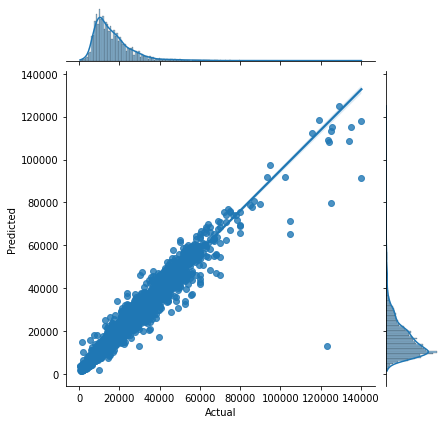

In [ ]:
test = pd.DataFrame({'Predicted':y_pred_rf_tuning,'Actual':y_test})
test = test.reset_index()
test = test.drop(['index'], axis=1)
test['Different'] = test['Actual'] - test['Predicted']
test['percentage (%)'] = ((test['Predicted']-test['Actual'])/test['Actual'])*100

fig = plt.figure(figsize=(16,8))
sns.jointplot(x='Actual', y='Predicted', data=test, kind="reg")



Berdasarkan grafik regression plot ini dapat dilihat data hasil prediksi cenderung merapat mendekati garis regresi membentuk hubungan yang linear. Semakin dekat data hasil prediksi terhadap garis linear maka dapat dikatakan bahwa hasil prediksi nya memiliki bias / error yang relatif kecil, namun jika semakin menjauhi garis regresi maka artinya data hasil prediksi nya memiliki bias yang tinggi.

Pada kasus ini, terlihat prediksi model pada mobil- mobil dengan harga yang lebih dari £100000 cenderung memiliki error yang tinggi.

### **Feature Importance**

Untuk dapat mengetahui sebenarnya fitur apa saja yang sangat memengaruhi target (price), kita dapat mengeceknya melalui function feature_importances_ pada model random forest yang digunakan.

In [ ]:
transformer.transformers_

[('binary', BinaryEncoder(), ['model', 'merk']),
 ('onehot',
  OneHotEncoder(drop='first', handle_unknown='ignore'),
  ['transmission', 'fuelType']),
 ('remainder', 'passthrough', [1, 3, 5, 6, 7])]

In [ ]:
print(transformer.transformers_[0][1].get_feature_names())
print(transformer.transformers_[1][1].get_feature_names())

['model_0', 'model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6', 'model_7', 'merk_0', 'merk_1', 'merk_2', 'merk_3']
['x0_Manual' 'x0_Other' 'x0_Semi-Auto' 'x1_Electric' 'x1_Hybrid'
 'x1_Other' 'x1_Petrol']


In [ ]:
num_col = ['year', 'mileage', 'tax', 'mpg', 'engineSize',]
feature = list(transformer.transformers_[0][1].get_feature_names())+list((transformer.transformers_[1][1].get_feature_names()))+num_col
feature

['model_0',
 'model_1',
 'model_2',
 'model_3',
 'model_4',
 'model_5',
 'model_6',
 'model_7',
 'merk_0',
 'merk_1',
 'merk_2',
 'merk_3',
 'x0_Manual',
 'x0_Other',
 'x0_Semi-Auto',
 'x1_Electric',
 'x1_Hybrid',
 'x1_Other',
 'x1_Petrol',
 'year',
 'mileage',
 'tax',
 'mpg',
 'engineSize']

In [ ]:
feature_importances = pd.DataFrame(data = rf_tuning[1].feature_importances_, 
                                   index = feature, 
                                   columns = ["coef"])
feature_importances.sort_values(by = ["coef"], ascending = True, inplace = True)
feature_importances

,coef
x1_Electric,0.000001
x0_Other,0.000003
x1_Other,0.000232
x1_Hybrid,0.002406
model_1,0.009467
model_2,0.009647
model_7,0.009830
model_6,0.010860
model_3,0.011900
model_0,0.012200


<AxesSubplot:>

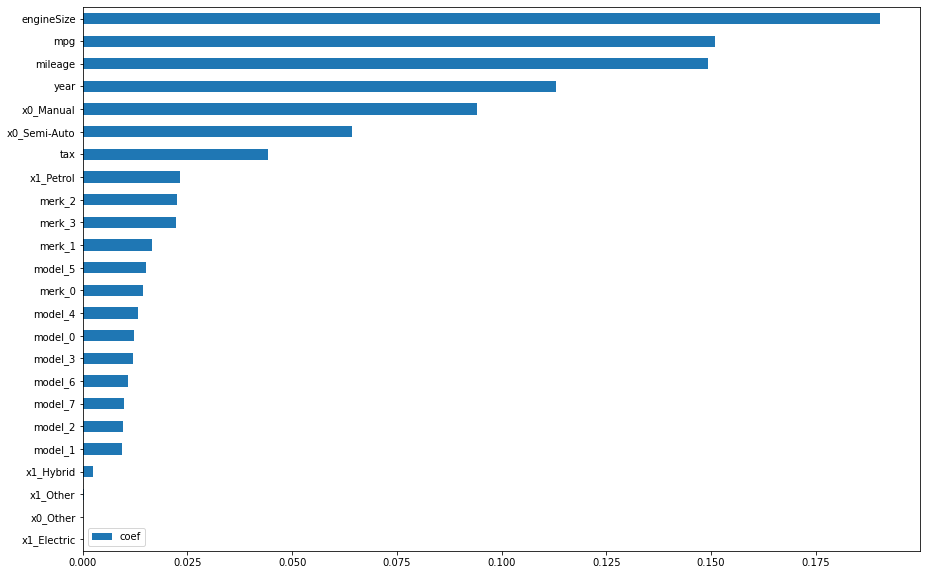

In [ ]:
feature_importances.plot(kind = "barh", figsize = (15,10))

Berdasarkan feature importance diatas, maka fitur yang paling berpengaruh terhadap harga adalah fitur enginesize (kapasitas mesin), mpg (miles per galon), mileage (jarak tempuh), year (tahun produksi mobil).

# Model Improvement

Berdasarkan hasil model sebelumnya yang kurang optimal, pada sesi ini akan dilakukan model improvement agar hasil prediksi model menjadi lebih baik.

### Feature Engineering

***Tax recognition for disability's car***

Berdasarkan hasil EDA sebelumnya, dapat diketahui bahwa kaum disabilitas dapat memiliki ***tax*** bernilai ***0.0***. Berdasarkan hal tersebut, feature engineering dapat dibuat berdasarkan informasi tersebut.

In [ ]:
df_new4 = df_new3.copy()
df_new4['taxRecognition'] = np.where(df_new4['tax'] == 0.0, 1, 0)
df_new4[df_new4['taxRecognition'] == 1].head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk,taxRecognition
30,A1,2015,9500,Automatic,54754,Diesel,0,76.3,1.6,Audi,1
50,A4,2016,12750,Manual,52561,Diesel,0,74.3,2.0,Audi,1
58,A3,2016,10200,Manual,66369,Diesel,0,83.1,1.6,Audi,1
60,A1,2013,7000,Manual,76269,Diesel,0,74.3,1.6,Audi,1
69,A1,2016,10800,Manual,18181,Petrol,0,67.3,1.0,Audi,1


***Tax Anomaly***

Berdasarkan hasil evaluasi model sebelumnya, terdapat nilai prediksi yang termasuk ke dalam ***contextual outlier*** yang menebak harga dengan selisih yang sangat jauh.

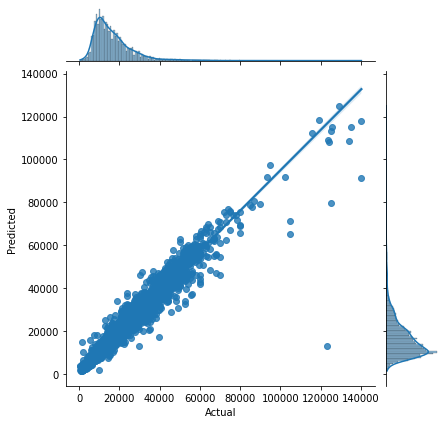

In [ ]:
sns.jointplot(x='Actual', y='Predicted', data=test, kind="reg")

Setelah diperiksa, data tersebut adalah mobil dengan merk ***BMW*** dan model ***2 Series*** seperti yang dapat dilihat di bawah ini.

In [ ]:
display(test[(test['Actual'] > 120000) & (test['Predicted'] < 20000)])

display(df_new3[df_new3['price'] == 123456])

,Predicted,Actual,Different,percentage (%)
6364,12950.611511,123456,110505.388489,-89.509938


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
14130,2 Series,2015,123456,Semi-Auto,33419,Diesel,20,68.9,2.0,BMW


Kemudian diputuskan untuk meninjau data dengan fitur ***price*** di atas 80000 seperti di bawah ini.

In [ ]:
df_new3.sort_values('price', ascending=False).head(50)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk
49917,G Class,2020,159999,Semi-Auto,1350,Petrol,145,21.4,4.0,Mercy
53613,G Class,2020,154998,Automatic,3000,Petrol,150,21.4,4.0,Mercy
43819,SL CLASS,2011,149948,Automatic,3000,Petrol,570,21.4,6.2,Mercy
4743,R8,2020,145000,Semi-Auto,2000,Petrol,145,21.1,5.2,Audi
52357,A Class,2019,140319,Semi-Auto,785,Petrol,150,22.1,4.0,Mercy
50103,G Class,2018,139995,Semi-Auto,13046,Petrol,145,21.4,4.0,Mercy
43822,G Class,2019,139948,Automatic,12000,Petrol,145,21.4,4.0,Mercy
52725,A Class,2019,139559,Semi-Auto,1000,Petrol,145,22.1,4.0,Mercy
52435,A Class,2020,138439,Semi-Auto,1000,Petrol,145,22.1,4.0,Mercy
2242,R8,2020,137995,Semi-Auto,70,Petrol,145,21.1,5.2,Audi


Setelah diperiksa, terdapat anomali pada data yang termasuk ***contextual outlier*** di atas karena memiliki fitur ***tax*** yang bernilai ***20***. Sedangkan rata-rata mobil dengan fitur ***price*** di atas ***80000*** memiliki tax rata-rata ***140-150*** seperti plot di bawah ini.

<AxesSubplot:xlabel='price', ylabel='tax'>

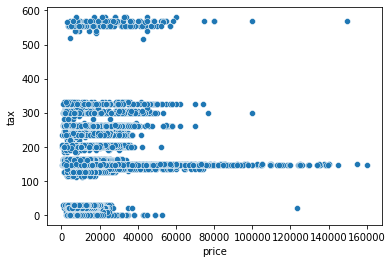

In [ ]:
sns.scatterplot(x='price', y='tax', data=df_new4)

Setelah ditinjau lebih lanjut, **terdapat informasi bahwa mobil yang memiliki harga di atas 80000 atau mobil dengan harga yang mahal memiliki tax yang cenderung murah (di kisaran £100-200) disebabkan oleh aturan pajak kendaraan Inggris raya yang mendasarkan untuk mematok pajak berdasarkan emisi karbon dan juga jenis bahan bakar kendaraan (https://www.gov.uk/vehicle-tax-rate-tables).** Mobil- mobil murah cenderung memiliki emisi karbon yang tinggi dan berbahan bakar **petrol** sehingga pajak kendaraan yang dibayarkan akan lebih mahal.

Dari hasil tersebut, terdapat mobil yang memiliki ***tax*** di bawah dan di atas rata-rata mobil mahal lainnya. Berdasarkan hasil tersebut, akan dibuat fitur baru yang untuk membedakan data-data tersebut.

In [ ]:
df_new5 = df_new4.copy()
df_new5['taxAnomaly'] = np.where(((df_new5['price'] >= 80000) & ((df_new5['tax'] > 200) | (df_new5['tax'] < 100))), 1, 0)
df_new5[df_new5['taxAnomaly'] == 1]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,merk,taxRecognition,taxAnomaly
14130,2 Series,2015,123456,Semi-Auto,33419,Diesel,20,68.9,2.0,BMW,0,1
15826,M4,2016,99950,Automatic,771,Petrol,300,33.2,3.0,BMW,0,1
43819,SL CLASS,2011,149948,Automatic,3000,Petrol,570,21.4,6.2,Mercy,0,1
49385,G Class,2015,99850,Semi-Auto,10000,Petrol,570,20.5,5.5,Mercy,0,1


***Data Splitting***

Pada sesi ini data akan dibagi menjadi 2 gugus, yaitu gugus training dan gugus testing. Data akan dibagi dengan proporsi 80% untuk data training dan 20% untuk data testing.

In [ ]:
X_imp = df_new5.drop(['price'], axis=1)
y_imp = df_new5['price']

X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_imp,
                                                                    y_imp,
                                                                    stratify=df_new5['taxAnomaly'],
                                                                    test_size = 0.2,
                                                                    random_state = 2022)

### Modelling

In [ ]:
rf = RandomForestRegressor(random_state=2022)

score_mape = []
score_R2 = []

# Prediksi pada test set
model = Pipeline([
    ('preprocessing', transformer),
    ('model', rf)
])

model.fit(X_train_imp, y_train_imp)
y_pred_imp = model.predict(X_test_imp)
score_mape.append(mean_absolute_percentage_error(y_test_imp, y_pred_imp))
score_R2.append(r2_score(y_test_imp, y_pred_imp))
  
score_before_tuning_imp = pd.DataFrame(data={'MAPE': score_mape, 'R2': score_R2}, index=['RandomForest'])
score_before_tuning_imp

,MAPE,R2
RandomForest,0.072772,0.958431


### Hyperparameter tuning

In [ ]:
# number of trees in the random forest
n_estimators_imp = [5, 20, 50, 100]

# number of features in consideration at every split
max_features_imp = ['auto', 'sqrt'] 

# maximum number of levels allowed in each decision tree
max_depth_imp = [int(x) for x in np.linspace(10, 120, num = 12)]

# minimum sample number to split a node
min_samples_split_imp = [2, 6, 10]

# minimum sample number that can be stored in a leaf node
min_samples_leaf_imp = [1, 3, 4]

# method used to sample data points
bootstrap_imp = [True, False] 

random_grid_imp = {
    'model__n_estimators': n_estimators_imp,
    'model__max_features': max_features_imp,
    'model__max_depth': max_depth_imp,
    'model__min_samples_split': min_samples_split_imp,
    'model__min_samples_leaf': min_samples_leaf_imp,
    'model__bootstrap': bootstrap_imp
}

In [ ]:
# Benchmark model dengan hyperparameter tuning
rf = RandomForestRegressor(random_state=2022)

# Membuat algorithm chains
estimator_rf_imp = Pipeline([
    ('preprocessing', transformer),
    ('model', rf)
])

crossval = KFold(n_splits=5, shuffle=True, random_state=2022)

# Hyperparameter tuning
random_rf_imp = RandomizedSearchCV(
    estimator_rf_imp, 
    param_distributions = random_grid_imp,
    n_iter = 50,
    cv = crossval, 
    scoring = 'neg_mean_absolute_percentage_error', 
    n_jobs = -1,
    random_state = 2022  
)

In [ ]:
random_rf_imp.fit(X_train_imp, y_train_imp)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=2022, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('binary',
                                                                               BinaryEncoder(),
                                                                               ['model',
                                                                                'merk']),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['transmission',
                                                                                'fuelType'])])),
                                             ('model',
                                              RandomForestRegressor(random_state=2022))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'model__bootstrap': [True, False],
                                        'model__max_depth': [10, 20, 30, 40, 50,
                                                             60, 70, 80, 90,
                                                             100, 110, 120],
                                        'model__max_features': ['auto', 'sqrt'],
                                        'model__min_samples_leaf': [1, 3, 4],
                                        'model__min_samples_split': [2, 6, 10],
                                        'model__n_estimators': [5, 20, 50,
                                                                100]},
                   random_state=2022,
                   scoring='neg_mean_absolute_percentage_error')

In [ ]:
# Cek skor dan params terbaik
print('Random Forest')
print('Best_score:', random_rf_imp.best_score_)
print('Best_params:', random_rf_imp.best_params_)

Random Forest
Best_score: -0.07438969536078843
Best_params: {'model__n_estimators': 20, 'model__min_samples_split': 6, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 20, 'model__bootstrap': False}


### Evaluation

**Performance Comparison**

Perbandingan performa model Random Forest sebelum dan sesudah dilakukan hyperparameter tuning.

In [ ]:
score_default_imp = pd.DataFrame(score_before_tuning_imp.loc['RandomForest']).T
score_default_imp.index = ['Random Forest Before Tuning']
score_default_imp

,MAPE,R2
Random Forest Before Tuning,0.072772,0.958431


In [ ]:
# After Tuning
# Model random forest
model_imp = {'Rf': RandomForestRegressor(random_state=2022)}

# Define model terhadap estimator terbaik
rf_tuning_imp = random_rf_imp.best_estimator_

# Fitting model
rf_tuning_imp.fit(X_train_imp, y_train_imp)

# Predict test set
y_pred_rf_tuning_imp = rf_tuning_imp.predict(X_test_imp)

# Simpan nilai metrics RMSE, MAE & MAPE setelah tuning
mape_rf_tuning = mean_absolute_percentage_error(y_test_imp, y_pred_rf_tuning_imp)
r2_rf_tuning = r2_score(y_test_imp, y_pred_rf_tuning_imp)

index = ['Random Forest After Tuning']
score_after_tuning_imp = pd.DataFrame({'MAPE': mape_rf_tuning, 'R2': r2_rf_tuning, }, index=index)
score_after_tuning_imp

,MAPE,R2
Random Forest After Tuning,0.070287,0.964239


setelah dilakukan hyperparameter, model mengalami peningkatan performa (nilai MAPE berkurang dan nilai R-Squared meningkat). Hal ini berarti proses hyperparameter yang dilakukan berhasil karena score nya membaik dibanding sebelumnya.

| **Random Forest Regressor** | **MAPE** | **R-Squared** |
| --- | --- | --- |
| before tuning | 0.072772 | 0.958431 |
| after tuning | 0.070287 | 0.964239 | 

#### **Perbandingan Hasil Prediksi Random Forest Regressor dengan Data Actual**

<Figure size 1152x576 with 0 Axes>

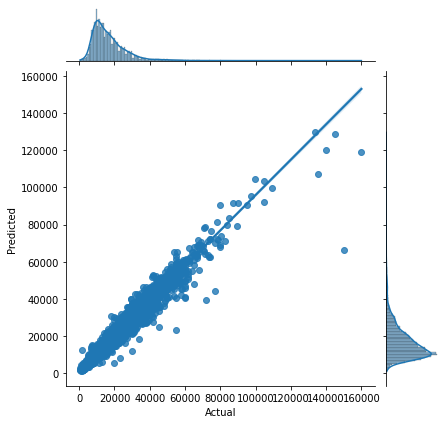

In [ ]:
test_imp = pd.DataFrame({'Predicted':y_pred_rf_tuning_imp,'Actual':y_test_imp})
test_imp = test_imp.reset_index()
test_imp = test_imp.drop(['index'], axis=1)
test_imp['Different'] = test_imp['Actual'] - test_imp['Predicted']
test_imp['percentage (%)'] = ((test_imp['Predicted']-test_imp['Actual'])/test_imp['Actual'])*100

fig = plt.figure(figsize=(16,8))
sns.jointplot(x='Actual', y='Predicted', data=test_imp, kind="reg")

### **Feature Importance**

Untuk dapat mengetahui sebenarnya fitur apa saja yang sangat memengaruhi target (price), kita dapat mengeceknya melalui function feature_importances_ pada model random forest yang digunakan

In [ ]:
transformer.transformers_

[('binary', BinaryEncoder(), ['model', 'merk']),
 ('onehot',
  OneHotEncoder(drop='first', handle_unknown='ignore'),
  ['transmission', 'fuelType']),
 ('remainder', 'passthrough', [1, 3, 5, 6, 7, 9, 10])]

In [ ]:
print(transformer.transformers_[0][1].get_feature_names())
print(transformer.transformers_[1][1].get_feature_names())

['model_0', 'model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6', 'model_7', 'merk_0', 'merk_1', 'merk_2', 'merk_3']
['x0_Manual' 'x0_Other' 'x0_Semi-Auto' 'x1_Electric' 'x1_Hybrid'
 'x1_Other' 'x1_Petrol']


In [ ]:
num_col_imp = ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'taxRecognition', 'taxAnomaly']
feature_imp = list(transformer.transformers_[0][1].get_feature_names())+list((transformer.transformers_[1][1].get_feature_names()))+num_col_imp
feature_imp

['model_0',
 'model_1',
 'model_2',
 'model_3',
 'model_4',
 'model_5',
 'model_6',
 'model_7',
 'merk_0',
 'merk_1',
 'merk_2',
 'merk_3',
 'x0_Manual',
 'x0_Other',
 'x0_Semi-Auto',
 'x1_Electric',
 'x1_Hybrid',
 'x1_Other',
 'x1_Petrol',
 'year',
 'mileage',
 'tax',
 'mpg',
 'engineSize',
 'taxRecognition',
 'taxAnomaly']

In [ ]:
feature_importances_imp = pd.DataFrame(data = rf_tuning_imp[1].feature_importances_, 
                                       index = feature_imp, 
                                       columns = ["coef"])
feature_importances_imp.sort_values(by = ["coef"], ascending = True, inplace = True)
feature_importances_imp

,coef
x0_Other,0.000002
x1_Electric,0.000013
x1_Other,0.000146
taxRecognition,0.001745
taxAnomaly,0.001927
x1_Hybrid,0.002524
model_1,0.006148
merk_0,0.006720
model_6,0.007787
model_7,0.008847


<AxesSubplot:>

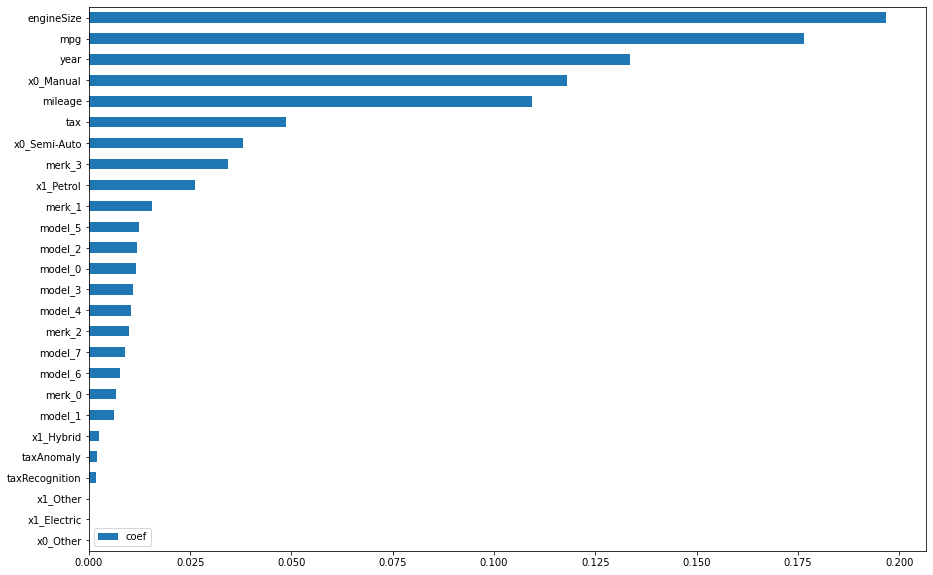

In [ ]:
feature_importances_imp.plot(kind = "barh", figsize = (15,10))

Berdasarkan feature importance diatas setelah dilakukan improvement model, terdapat sedikit perbedaan dari feature importance sebelumnya dimana fitur yang paling berpengaruh kali ini terhadap harga adalah fitur enginesize (kapasitas mesin), mpg (miles per galon), year (tahun produksi mobil), transmisi kendaraan.

# Conclusion

## **Conclusion**

* Berdasarkan hasil EDA, terlihat mobil bekas yang paling banyak terjual adalah mobil merk Ford. Hal ini disebabkan oleh harga mobil Ford yang cenderung terjangkau (carblog.co.uk, "Why Is Ford The Most Popular Car Make In The UK?". https://www.carblog.co.uk/why-is-ford-the-most-popular-car-make-in-the-uk/).

* Berdasarkan hasil EDA, terlihat banyak mobil jenis city car dan mobil- mobil kecil seperti Ford Fiesta dan VW Golf laku terjual di Inggris Raya. Hal ini mengindikasikan preferensi konsumen Inggris Raya terhadap mobil- mobil jenis tersebut.

* Berdasarkan hasil data feature importance setelah model improvement, maka fitur yang paling berpengaruh terhadap perbedaan harga jual mobil bekas di UK adalah fitur kapasitas mesin dari mobil itu sendiri. Kemudian disusul oleh efisiensi mobil yang ditunjukkan oleh satuan mile per gallon. Hal ini cukup beralasan karena semakin tinggi kapasitas mesin mobil artinya semakin besar pula tenaga mobil tersebut yang menyebabkan harga mobil semakin mahal. Sementara untuk fitur mpg, efisiensi mobil banyak mempengaruhi harga dan juga fitur lainnya, seperti mileage dan tax. Mobil yang efisien juga berpengaruh pada biaya yang harus dikeluarkan untuk bahan bakar.

* Dilihat dari hasil score metric yang digunakan pada model setelah improvement. Model Random Forest Regressor menghasilkan nilai skor **MAPE** sebesar **0.070287 atau 7% error rate**. Berdasarkan ***Lewis (1982)***, nilai skor MAPE yang berada di bawah 10% dapat dikategorikan bahwa hasil prediksi nya **"Sangat Baik"**. 
Sebagai contoh, jika data aktual harga mobil sebesar 100000, maka harga prediksi akan berada di rentang minimal -7% hingga +7% dari harga aktual, jika ternyata berada di luar rentang tersebut artinya terjadi bias pada hasil prediksi. 

* Sementara untuk **R-Squared**, model menghasilkan skor sebesar **0.964239 atau 96%**, yang artinya model dapat menjelaskan variabel dependent (price) sebesar 96%, sementara yang sisanya 4% dijelaskan oleh variabel lain diluar variabel independent atau secara sederhana dapat dikatakan bahwa fitur-fitur input yang digunakan cukup berpengaruh terhadap perubahan harga yang menjadi target prediksi. Berdasarkan ***Hair et al (2011)*** nilai skor R-Squared yang berada di atas 0.75 / 75% termasuk kategori **"Kuat"** 
  

## **Recommendation / Next Suggestion**

Berikut adalah beberapa hal yang dapat dilakukan untuk pengembangan model dan bisnis agar bisa lebih baik lagi.

* Melihat kembali data predict, lalu menganalisa data-data yang memiliki error yang paling tinggi, dan membandingkan fitur-fitur mana saja yang menyebabkan model menghasilkan error tersebut.

* Jika memungkinkan, dilakukan penambahan fitur yang memiliki hubungan yang lebih korelatif dengan fitur harga. Untuk kasus ini, mungkin dapat ditambahkan fitur seperti kondisi fisik mobil, kelengkapan surat-surat, masa berlaku pajak, dll sehingga diharapkan dapat meningkatkan kemampuan model dalam memprediksi harga

* Menambah fitur kategori model mobil agar lebih detail. Contohnya BMW 2 Series,  BMW 2 Series Tourer, dan BMW 2 Series Coupe.

* Melakukan *data cleaning* yang lebih mendalam pada fitur-fitur data yang masih bias pada dataset ini. Contohnya pada fitur fuelType masih terdapat tipe bahan bakar "other", hal ini sebaiknya diubah dan disesuaikan dengan jenis bahan bakar yang sebenarnya digunakan. Hal ini juga berlaku untuk fitur-fitur lainnya yang memiliki value yang berbeda dari yang data real sebenarnya. Dengan tujuan untuk mengurangi bias yang terjadi pada data-data tersebut. Karena data yang *clean* adalah kunci utama untuk bisa menghasilkan model yang terbaik

* Mencoba beberapa teknik feature engineering lainnya seperti binning pada data-data numerikal atau scaling menggunakan logaritmic scale pada data-data yang memiliki distribusi tidak normal.

* Dikarenakan tipe mobil yang banyak terjual adalah tipe city car yang praktis, maka PT ABC dapat menggencarkan promosi penjualan mobil- mobil sejenis dan juga memprioritaskan untuk membeli mobil bekas dari tipe- tipe tersebut.